<style>
    .title_container {
        margin: auto;
        background: rgb(81,92,103);
        background: linear-gradient(90deg, rgba(81,92,103,1) 36%, rgba(12,35,66,1) 62%);
        border-radius: 7px;
        color: white;
        text-align:center;
        width:75%;
        padding-top:2%;
        padding-bottom:2%;
    }
    
    .question_container {
        margin: auto;
        background: rgb(84,138,142);
        background: linear-gradient(90deg, rgba(84,138,142,1) 41%, rgba(145,201,73,1) 81%);
        border-radius: 7px;
        color: white;
        text-align:left;
        width:75%;
        padding-top:1%;
        padding-bottom:1%;
        padding-left: 2%;
        margin-top:2%;
    }
    
    .question_container p {
        font-size: 16px;
    }
    
    .code_span {
        background-color: #E2E7EC;
        padding:2px;
        border-radius:1px;
        font-family: Consolas,monaco,monospace;
        color:black;
    }
</style>

<div class ='title_container'>
    <h1> Análisis de Datos II </h1>
    <h2> Profesor: Oldemar Rodríguez </h2>
    <h3> Estudiante: Jimmy Calvo Monge </h3>
    <h3> Carné: B31281 </h3>
    <hr style='color:white; width:80%;'>
    <h4> TAREA 4 </h4>
    <h4> Fecha de entrega: 18 de Setiembre de 2022 </h4>
</div>

Importamos los módulos necesarios para resolver esta tarea.

In [31]:
import graphviz # Debe instalar este paquete y programa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn import tree
from pandas import DataFrame
import seaborn as sns
import time

In [67]:
def indices_general(MC, nombres = None):
    precision_global = np.sum(MC.diagonal()) / np.sum(MC)
    error_global     = 1 - precision_global
    precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
    if nombres!=None:
        precision_categoria.columns = nombres
    return {"Matriz de Confusión":MC, 
            "Precisión Global":   precision_global, 
            "Error Global":       error_global, 
            "Precisión por categoría":precision_categoria}

import matplotlib.ticker as mticker

def distribucion_variable_predecir(data:pd.DataFrame,variable_predict:str, ax = None):
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (15,10), dpi = 200)
    colors = list(dict(**mcolors.CSS4_COLORS))
    df = pd.crosstab(index = data[variable_predict],columns = "valor") / data[variable_predict].count()
    countv = 0
    titulo = "Distribución de la variable %s" % variable_predict
    
    for i in range(df.shape[0]):
        ax.barh(1, df.iloc[i], left = countv, align = 'center', color = colors[11 + i], label = df.iloc[i].name)
        countv = countv + df.iloc[i]
        
    ax.set_xlim(0,1)
    ax.set_yticklabels("")
    ax.set_ylabel(variable_predict)
    ax.set_title(titulo)
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(['{:.0%}'.format(x) for x in ticks_loc])
    
    countv = 0
    for v in df.iloc[:,0]:
        ax.text(np.mean([countv, countv + v]) - 0.03, 1 , '{:.1%}'.format(v), color = 'black', fontweight = 'bold')
        countv = countv + v
    ax.legend(loc = 'upper center', bbox_to_anchor = (1.08, 1), shadow = True, ncol = 1)
    
def poder_predictivo_categorica(data: pd.DataFrame, var: str, variable_predict: str, ax=None):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize = (15, 10), dpi = 200)
    df = pd.crosstab(index = data[var], columns = data[variable_predict])
    df = df.div(df.sum(axis = 1), axis = 0)
    titulo = "Distribución de la variable %s según la variable %s" % (var, variable_predict)
    df.plot(kind = 'barh', stacked = True,   legend = True, ax = ax,
            xlim = (0, 1), title   = titulo, width = 0.8)
            
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(['{:.0%}'.format(x) for x in ticks_loc])
    ax.legend(loc = 'upper center', bbox_to_anchor = (1.08, 1), 
              shadow = True, ncol = 1)
              
    for bars in ax.containers:
        plt.setp(bars, width = .9)
    for i in range(df.shape[0]):
        countv = 0
        for v in df.iloc[i]:
            ax.text(np.mean([countv, countv+v]) - 0.03, i,
                    '{:.1%}'.format(v), color = 'black', fontweight = 'bold')
            countv = countv + v
            
def poder_predictivo_numerica(data:pd.DataFrame, var:str, variable_predict:str):
    sns.FacetGrid(data, hue = variable_predict, height = 8, aspect = 1.8).map(sns.kdeplot, var, shade = True).add_legend()
    
### Clase MatConf de la Tarea Anterior

class MatConf:
    
    def __init__(self,matriz):
        
        self.mat_conf = matriz
        
        VN = self.mat_conf[0,0]
        VP = self.mat_conf[1,1]
        FP = self.mat_conf[0,1]
        FN = self.mat_conf[1,0]
        
        dict_medidas = {
            'Precisión Global' : (VN+VP)/(VN+FP+FN+VP),
            'Error Global' : (FN+FP)/(VN+FP+FN+VP),
            'Precisión Positiva (PP)' : VP/(FN+VP),
            'Precisión Negativa (PN)' : VN/(VN+FP),
            'Proporción de Falsos Positivos (PFP)' : FP/(VN+FP),
            'Proporción de Falsos Negativos (PFN)' : FN/(FN+VP),
            'Asertividad Positiva (AP)' : VP/(FP+VP),
            'Asertividad Negativa (AN)' : VN/(VN+FN)
        }
        self.dict_medidas = dict_medidas
        
    def __str__(self):
        mensaje="Estos son los resultados para esta matriz de confusion:"
        for key in list(self.dict_medidas.keys()):
            mensaje = mensaje + f"\n - {key}: {self.dict_medidas[key]}"
        return mensaje

<div class='question_container'>
    <h2> Pregunta 1 </h2>
    <p> Para la Tabla de Datos que se muestra seguidamente (la variable a predecir es Tipo): </p>
    <table>
        <tr>
            <th>Tipo</th>
            <th>Color</th>
            <th>Tamaño</th>
        </tr>
        <tr><td>1</td> <td>Amarillo</td> <td>Grande</td></tr>
        <tr><td>1</td> <td>Amarillo</td> <td>Grande</td></tr>
        <tr><td>0</td> <td>Amarillo</td> <td>Pequeño</td></tr>
        <tr><td>1</td> <td>Azul</td> <td>Pequeño</td></tr>
        <tr><td>0</td> <td>Azul</td> <td>Grande</td></tr>
        <tr><td>0</td> <td>Azul</td> <td>Grande</td></tr>
        <tr><td>0</td> <td>Azul</td> <td>Pequeño</td></tr>
        <tr><td>1</td> <td>Amarillo</td> <td>Pequeño</td></tr>
        <tr><td>0</td> <td>Azul</td> <td>Grande</td></tr>
        <tr><td>1</td> <td>Azul</td> <td>Grande</td></tr>
        <tr><td>1</td> <td>Azul</td> <td>Grande</td></tr>
    </table>
    <ol>
        <li>Calcule la información ganada usando el índice Gini para las 2 posibles divisiones (iniciando con la variable Color o iniciando con la variable Tamaño) ¿Cuál división es la mejor? ¿Por qué?</li>
        <li> De acuerdo al resultado del ítem anterior, genere el árbol que representa todas las reglas de decisión. En caso de nodos hoja donde exista un empate en las clases de la variable a predecir puede clasificar como usted desee. Puede utilizar cualquier herramienta para dibujar el árbol, inclusive puede hacerlo a mano. El dibujo debe ser completamente legible.</li>
    </ol>
</div>

Sea $N_1$ la división con la variable Color. Entonces dividimos en dos nodos, $N_{1,1} = \{ \text{Color = Amarillo}\}$ y $N_{1,2}=\{\text{Color = Azul}\}$ (Estoy usando la notación de la pregunta 2 porque la resolví primero 😅). Aquí tenemos

$$
\begin{align*}
N_{1,1}=\begin{pmatrix}
    '0' & 1 \\
    '1' & 3 \\
    \end{pmatrix}, \quad N_{1,2}=\begin{pmatrix}
    '0' & 4 \\
    '1' & 3 \\
    \end{pmatrix}
\end{align*}
$$

y por lo tanto, los coeficientes de GINI vienen dados por

$$
\begin{align*}
\text{GINI}(N_{1,1}) &= 1 - \left(\frac{1}{4}\right)^2 - \left(\frac{3}{4}\right)^2 = 0.375 \\
\text{GINI}(N_{1,2}) &= 1 - \left(\frac{4}{7}\right)^2 - \left(\frac{3}{7}\right)^2 = 0.489796 \\
\end{align*}
$$

Esto implica que el $\text{GINI}_{\text{split}}$ viene dado por

$$
\begin{align*}
\text{GINI}_{\text{split}}(N_1) = \frac{4}{11}\cdot 0.375 + \frac{7}{11}\cdot 0.489796 = 0.448052.
\end{align*}
$$

Por su parte, el GINI del nodo padre es

$$
\begin{align*}
\text{GINI}(N) = 1 - \left(\frac{5}{11}\right)^2 - \left(\frac{6}{11}\right)^2 = 0.495868
\end{align*}
$$

Por tanto la información ganada con $N_1$ es 

$$
\begin{align*}
\text{IG}(N_1) = \text{GINI}(N) - \text{GINI}_{\text{split}}(N_1) = 0.495868 - 0.448052 = 0.047815.
\end{align*}
$$

Ahora, sea $N_2$, por su parte, la división con la variable Tamaño. Entonces dividimos en dos nodos, $N_{2,1} = \{ \text{Tamaño = Pequeño}\}$ y $N_{2,2}=\{\text{Tamaño = Grande}\}$. Aquí tenemos

$$
\begin{align*}
N_{2,1}=\begin{pmatrix}
    '0' & 2 \\
    '1' & 2 \\
    \end{pmatrix}, \quad N_{1,2}=\begin{pmatrix}
    '0' & 3 \\
    '1' & 4 \\
    \end{pmatrix}
\end{align*}
$$

y por lo tanto, los coeficientes de GINI vienen dados por

$$
\begin{align*}
\text{GINI}(N_{2,1}) &= 1 - \left(\frac{2}{4}\right)^2 - \left(\frac{2}{4}\right)^2 = 0.5 \\
\text{GINI}(N_{2,2}) &= 1 - \left(\frac{3}{7}\right)^2 - \left(\frac{4}{7}\right)^2 = 0.489796 \\
\end{align*}
$$

Esto implica que el $\text{GINI}_{\text{split}}$ viene dado por

$$
\begin{align*}
\text{GINI}_{\text{split}}(N_1) = \frac{4}{11}\cdot 0.5 + \frac{7}{11}\cdot 0.489796 = 0.493507.
\end{align*}
$$

Por tanto la información ganada con $N_2$ es 

$$
\begin{align*}
\text{IG}(N_2) = \text{GINI}(N) - \text{GINI}_{\text{split}}(N_2) = 0.495868 - 0.493507 = 0.002361.
\end{align*}
$$

Entonces $N_1$ nos da mayor información ganada, por lo que vamos a hacer el primer split con esta variable.El árbol que tiene TODAS las reglas de decisión posibles es el siguiente (al final puse cuántas observaciones fueron clasificadas correctamente en cada nodo terminal).

<div style="text-align:center; width:50%; margin: auto;">
    <img src="arbol.png">
</div>

<div class='question_container'>
    <h2> Pregunta 2 </h2>
    <p> Supongamos que tenemos un Árbol de Decisión
con tres clases $A,B,C$. Se tiene que decidir cómo dividir el nodo padre:</p>
    <p>$$ 
    \begin{align*}
    N=\begin{pmatrix}
    A & 100 \\
    B & 50 \\
    C & 60
    \end{pmatrix}
    \end{align*}
    $$</p>
    <p> para esto hay dos posibles divisiones. La primera posible división $N_1$ divide el nodo $N$ en los $2$ siguientes nodos: </p>
    $$
    \begin{align*}
    N_{1,1}=\begin{pmatrix}
    A & 62 \\
    B & 8 \\
    C & 0
    \end{pmatrix}, \quad N_{1,2}=\begin{pmatrix}
    A & 38 \\
    B & 42 \\
    C & 60
    \end{pmatrix}
    \end{align*}
    $$
    <p> La segunda opción de división $N_2$ para el nodo $N$ es la siguiente en $3$ nodos: </p>
        $$
    \begin{align*}
    N_{2,1}=\begin{pmatrix}
    A & 65 \\
    B & 20 \\
    C & 0
    \end{pmatrix}, \quad N_{2,2}=\begin{pmatrix}
    A & 21 \\
    B & 19 \\
    C & 20
    \end{pmatrix}, \quad N_{2,3}=\begin{pmatrix}
    A & 14 \\
    B & 11 \\
    C & 40
    \end{pmatrix}
    \end{align*}
    $$
    <ol>
        <li>Calcule la información ganada usando el índice de Gini para las dos posibles divisiones ($N_1$ en $2$ nodos y $N_2$ en $3$ nodos). ¿Cuál división es la mejor?</li>
        <li>Otro índice utilizado para decidir cuál división es la mejor es la Complejidad (que también es utilizado como criterio en la poda de un árbol). Dado un índice $Q$ que puede ser Gini, se define la Complejidad de un árbol $T$ con nodos terminales $(t_j)_{1 \leq j \leq m}$ ($m$ = cantidad de nodos terminales) como sigue:
        $$
        \begin{align*}
        C_{\alpha}(T)=\sum_{j=1}^m n_jQ(t_j) + \alpha m,
        \end{align*}
        $$
        con $\alpha \geq 0$ y donde $n_j$ es la cardinalidad del nodo $t_j$. Dado un árbol grande $T_L$ y si $T \leq T_L$ denota que $T$ es un subárbol de $T_L$, entonces se define el Árbol Óptimo como sigue:
        $$
        \begin{align*}
        \hat{T_{\alpha}} = \min_{T\leq T_{\alpha}}C_{\alpha}(T)
        \end{align*}
        $$
        Si usamos como parámetro para la complejidad $\alpha = 25$ para cada nodo terminal y usando el índice de Gini para las dos posibles divisiones ($N_1$ en $2$ nodos o $N_2$ en $3$ nodos). ¿Cuál división es la mejor en el sentido de que minimiza la complejidad? ¿Para que valores de este criterio prefiere $N_1$ sobre $N_2$?</li>
    </ol>
</div>

**Respuestas:**

Calculamos $\text{GINI}(N_{1,1})$ y $\text{GINI}(N_{1,2})$ de la siguiente manera

$$
\begin{align*}
\text{GINI}(N_{1,1}) &= 1 - \left(\frac{62}{70}\right)^2 - \left(\frac{8}{70}\right)^2 - \left(\frac{0}{70}\right)^2 = 0.202448 \\
\text{GINI}(N_{1,2}) &= 1 - \left(\frac{38}{140}\right)^2 - \left(\frac{42}{140}\right)^2 - \left(\frac{60}{140}\right)^2 = 0.652653 \\
\end{align*}
$$

Esto implica que el $\text{GINI}_{\text{split}}$ viene dado por

$$
\begin{align*}
\text{GINI}_{\text{split}}(N_1) = \frac{70}{210}\cdot 0.202448 + \frac{140}{210}\cdot 0.652653 = 0.502585.
\end{align*}
$$

También, tenemos que $\text{GINI}(N)$ es igual a

$$
\begin{align*}
\text{GINI}(N) = 1 - \left(\frac{100}{210}\right)^2 - \left(\frac{50}{210}\right)^2 - \left(\frac{60}{210}\right)^2 =
0.634921
\end{align*}
$$

Por lo que la información ganada con $N_1$ es

$$
\begin{align*}
\text{IG}(N_1) = \text{GINI}(N) - \text{GINI}_{\text{split}}(N_1) = 0.634921-0.502585 = 0.132336.
\end{align*}
$$

Con $N_2$ tenemos una historia similar, note que 

$$
\begin{align*}
\text{GINI}(N_{2,1}) &= 1 - \left(\frac{65}{85}\right)^2 - \left(\frac{20}{85}\right)^2 - \left(\frac{0}{85}\right)^2 = 0.359862 \\
\text{GINI}(N_{2,2}) &= 1 - \left(\frac{21}{60}\right)^2 - \left(\frac{19}{60}\right)^2 - \left(\frac{20}{60}\right)^2 = 0.666111 \\
\text{GINI}(N_{2,3}) &= 1 - \left(\frac{14}{65}\right)^2 - \left(\frac{11}{65}\right)^2 - \left(\frac{40}{65}\right)^2 = 0.546272 \\
\end{align*}
$$

Esto implica que el $\text{GINI}_{\text{split}}$ viene dado por

$$
\begin{align*}
\text{GINI}_{\text{split}}(N_2) = \frac{85}{210}\cdot 0.359862 + \frac{60}{210}\cdot 0.666111 + \frac{65}{210}\cdot 0.546272  = 0.505060.
\end{align*}
$$

Así que la información ganada con $N_1$ es

$$
\begin{align*}
\text{IG}(N_2) = \text{GINI}(N) - \text{GINI}_{\text{split}}(N_2)= 0.634921-0.505060 = 0.129861.
\end{align*}
$$

Lo que quiere decir que $N_1$ es mejor, en términos de información ganada.

Si usamos el segundo criterio para calcular la complejidad entonces tendremos que, para $N_1$ se cumple
$$
\begin{align*}
C_{\alpha}(N_1) &= |N_{1,1}|\text{GINI}(N_{1,1}) + |N_{1,2}|\text{GINI}(N_{1,2}) + 2\alpha \\
&= 70 \cdot 0.202448 + 140 \cdot 0.652653 + 2\cdot 25 \\
&= 155.54278.
\end{align*}
$$
Para mientras que en $N_2$ se cumple que 
$$
\begin{align*}
C_{\alpha}(N_2) &= |N_{2,1}|\text{GINI}(N_{2,1}) + |N_{2,2}|\text{GINI}(N_{2,2}) + |N_{2,2}|\text{GINI}(N_{2,2}) + 3\alpha \\
&= 65 \cdot 0.359862 + 21 \cdot 0.666111 + 14 \cdot 0.546272 + 3\cdot 25 \\
&= 120.027169
\end{align*}
$$

Por lo que ahora es $N_2$ quien tiene la menor complejidad.

<div class='question_container'>
    <h2> Pregunta 3 </h2>
    <p> Realice las siguientes demostraciones que quedaron pendientes en la presentación teórica de Árboles de Decisión: </p>
    <ol>
        <li> Pruebe que $\Delta \text{Imp}(v) \geq 0$ y que $\Delta \text{Imp}(v) = 0$ si y solo si $p(s | v) = p(s \vert v_i) = p(s | v_d)$ para $s = 1, \cdots , r$.</li>
        <li> Sea la función $g : [0, 1]^r \to [0,\infty[$ definida por $g(x_1, \cdots, x_r) = \sum_{i\neq j} x_ix_j$ Pruebe que la función $g$ es una función de impureza (pruebe únicamente las propiedades a) y c)).</li>
        <li> Sea $v$ un nodo de $A_{\max}$, $v_i$ y $v_d$ sus hijos izquierdo y derecho respectivamente, $n_d = | v_d |, n_i = | v_i |, n_{sd} = | E_s \cap v_d |, n_{si} = | E_s \cap v_i|, p_i = \frac{| v_i |}{| v|}$ y $p_d = \frac{| v_d |}{| v|}$. Pruebe que:
            <ul>
                <li> $\Delta \text{Imp}(v) = \frac{1}{| v |^2 n_in_d}\sum_{s=1}^r (n_dn_{si}-n_in_{sd})^2.$ </li>
                <li> El nodo $v$ es puro si y solo si existe $h \in \{1,\cdots,r\}$ tal que $v \subseteq E_h$. </li>
            </ul>
        </li>
        <li> Si un objeto que es seleccionado al azar, cae en el nodo $v_t$ del árbol $A_{\max}$ y es clasificado en la clase a priori $i$, el costo esperado (estimado) de mala clasificación, dado el nodo $v_t$, se define como:
        $$
        c(v_t)=c(t)=\frac{1}{| v_t |}\min_{i=1,\cdots,r}\sum_{j=1}^r c(i| j) | E_j \cap v_t |
        $$
        Si se asumen costos unitarios, es decir, $c(i| j)=1$ para todo $i \neq j$, pruebe que:
        $$
        c(t)= 1- \frac{1}{| v_t |}\max_{j=1,\cdots,r}| E_j \cap v_t |.
        $$
        </li>
        <li>
            <ul>
                <li>Pruebe que $p(v_t)c(v_t) \geq p(v_i)c(v_i) + p(v_d)c(v_d)$.</li>
                <li>¿Es Falso o Verdadero? que la igualdad puede ocurrir aún cuando los nodos hijos $v_i$ y $v_d$ contengan una mezcla de objetos de distintas clases a priori.</li>
            </ul>
        </li>
        <li> El Costo-Complejidad de una rama $A_v$ de $A_{\max}$ se define como: 
            $$
            c_{\alpha}(A_v)= \sum_{u_t \in \widetilde{A}_{v}} c_{\alpha}(u_t).
            $$
            Pruebe que:
            $$
            c_{\alpha}(A_v)=\alpha |\widetilde{A}_{v}| + \sum_{u_t \in \widetilde{A}_{v}} p(u_t)c(u_t).
            $$
        </li>
        <li>
            Pruebe que un nodo $v$ es preferido a la rama $A_v$ si:
            $$
            \alpha \geq \frac{C(v)-c(A_v)}{|\widetilde{A}_{\alpha}| -1 }
            $$
        </li>
    </ol>
</div>

**Respuestas**

1. Recordemos que $\Delta \text{Imp}(v) = \text{Imp}(v) - [p(v_i)\text{Imp}(v_i) + p(v_d)\text{Imp}(v_d)]$, por definición tenemos que

$$
\begin{align*}
p(v_i)\text{Imp}(v_i) + p(v_d)\text{Imp}(v_d) = \frac{|v_i|}{|v|} \phi ( p(1|v_i), \cdots, p(r|v_i)) + \frac{|v_d|}{|v|} \phi ( p(1|v_d), \cdots, p(r|v_d))
\end{align*}
$$

Definamos $x= ( p(1|v_i), \cdots, p(r|v_i)), y = ( p(1|v_d), \cdots, p(r|v_d))$ y $\lambda = \frac{|v_i|}{|v|}$. Entonces la expresión anterior es igual a 

$$
\begin{align*}
\lambda \phi(x) + (1-\lambda)\phi(y) \quad (*)
\end{align*}
$$
ya que $1-\lambda = 1-\frac{|v_i|}{|v|} = \frac{|v| - |v_i|}{|v|} =\frac{|v_d|}{|v|}$. Ahora, como la función $\phi$ ers cóncava (por supuesto de la proposición), entonces se cumple 

$$
\begin{align*}
(*) &\leq \phi(\lambda x + (1-\lambda)y) \\
&=\phi \left( \frac{|v_i|}{|v|}p(1|v_i) + \frac{|v_d|}{|v|}p(1|v_d), \cdots,  \frac{|v_i|}{|v|}p(r|v_i) + \frac{|v_d|}{|v|}p(r|v_d)\right) \\
&= \phi \left( \frac{|v_i|}{|v|}\frac{|E_1 \cap v_i|}{|v_i|} + \frac{|v_d|}{|v|}\frac{|E_1 \cap v_d|}{|v_d|}, \cdots,   \frac{|v_i|}{|v|}\frac{|E_r \cap v_i|}{|v_i|} + \frac{|v_d|}{|v|}\frac{|E_r \cap v_d|}{|v_d|}\right) \\
&= \phi \left( \frac{|E_1 \cap v_i| + |E_1 \cap v_d| }{|v|}, \cdots, \frac{|E_r \cap v_i| + |E_r \cap v_d| }{|v|}\right),
\end{align*}
$$
y como $v_i$ y $v_d$ son disjuntos y $v_i \cup v_d = v$, esta última expresión es igual a
$$
\begin{align*}
\phi \left( \frac{|E_1 \cap v| }{|v|}, \cdots, \frac{|E_r \cap v|}{|v|}\right) = \phi(p(1|v), \cdots, p(r|v))= \text{Imp}(v).
\end{align*}
$$
Por la definición de ser estrictamente cóncava, la desigualdad anterior es una igualdad si y sólo si $x=y$ es decir si y sólo si $p(s|v_i)= p(s|v_d)$ para todo $s=1,\cdots,r$. En este caso entonces queda la igualdad $\phi(\lambda x + (1-\lambda)y)= \phi(x)$ es decir $\phi(p(1|v_i), \cdots, p(r|v_i))=\phi(p(1|v), \cdots, p(r|v))$ lo cual implica $p(s|v_i)= p(s|v)$ para todo $s=1,\cdots,r$ y por tanto tenemos $p(s|v)= p(s|v_i)= p(s|v_d)$ para todo $s=1,\cdots,r$

2. Primero notamos que si $\sum_{i=1}^rx_i=1$ entonces elevando al cuadrado tenemos 
$$
\begin{align*}
1=\left(\sum_{i=1}^rx_i\right)^2 = \sum_{i,j}^rx_ix_j = \sum_{i=1}x_i^2 + \sum_{i\neq j}x_ix_j = \sum_{i=1}^2 x_i^2 + g(x).
\end{align*}
$$
despejando se cumple que $g(x)=1-\sum_{i=1}^rx_i^2$. Ahora probamos que $g$ es función de impureza. Por lo anterior tenemos que
$$
\min\left\{g(x_1,\cdots,x_r) | \sum_{i=1}^r x_i=1 \right\} = \min \left\{ 1- \sum_{i=1}^r x_i^2 \right\} = 0.
$$
y eso es igual a $g(e_i)$ en cualquier vector canónico $e_i$. Por otro lado $g\left(\frac{1}{r},\cdots, \frac{1}{r}\right) = 1-\sum_{i=1}^r\frac{1}{r^2} = 1- \frac{1}{r}.$ Ahora, si $(x_1,\cdots,x_r) \in [0,1]^r$ es tal que $\sum_{i=1}^rx_i=1$ entonces $g(x_1,\cdots,x_r)=1-\sum_{i=1}^r x_i^2$, por tanto debemos probar que $\sum_{i=1}^r x_i^2 \leq \frac{1}{r}$ para tener la segunda propiedad de ser una función de impureza. Esto en realidad se deduce de una desigualdad de normas muy conocida:
$$
||x||_2 \leq \sqrt{r} ||x||_1 \text{ para todo } x \in \mathbb{R}^r.
$$
Finalmente demostramos la tercera propiedad de ser una función de impureza. Sea $\sigma \in S_r$ una permutación de $r$ elementos. Queremos demostrar que $g(x_1,\cdots,x_r)=g(x_{\sigma(1)},\cdots,x_{\sigma(r)})$. Note que si $i\neq j$ entonces $\sigma(i)\neq \sigma(j)$ por lo que los sumandos $x_ix_j$ tienen una correspondencia unívoca con los sumandos $x_{\sigma(i)}x_{\sigma(j)}$ y esto implica que su suma al final será igual. Por ende $g$ queda constante bajo permutaciones.

3. Por definición , $\Delta \text{Imp}(v) = \text{Imp}(v) - [p_i\text{Imp}(v_i) + p_d\text{Imp}(v_d)]$, por lo que, usando la definición de $g$, tenemos que

$$
\begin{align*}
\Delta \text{Imp}(v) &= \left( 1 - \sum_{s=1}^r p(s|v)^2 \right) - p_i  \left( 1 - \sum_{s=1}^r p(s|v_i)^2 \right) - p_d \left( 1 - \sum_{s=1}^r p(s|v_d)^2 \right) \\
&=\left( 1 - \sum_{s=1}^r \frac{|E_s \cap v|^2}{|v|^2} \right) - p_i  \left( 1 - \sum_{s=1}^r \frac{|E_s \cap v_i|^2}{|v_i|^2} \right) - p_d \left( 1 - \sum_{s=1}^r \frac{|E_s \cap v_d|^2}{|v_d|^2} \right) \\
&=\left( 1 - \sum_{s=1}^r \frac{|E_s \cap v|^2}{|v|^2} \right) - \frac{|v_i|}{|v|}  \left( 1 - \sum_{s=1}^r \frac{|E_s \cap v_i|^2}{|v_i|^2} \right) - \frac{|v_d|}{|v|} \left( 1 - \sum_{s=1}^r \frac{|E_s \cap v_d|^2}{|v_d|^2} \right) \\
&=1 -  \frac{|v_i|}{|v|} - \frac{|v_d|}{|v|} - \sum_{s=1}^r \frac{|E_s \cap v|^2}{|v|^2} + \frac{|v_i|}{|v|}\sum_{s=1}^r \frac{|E_s \cap v_i|^2}{|v_i|^2} + \frac{|v_d|}{|v|}\sum_{s=1}^r \frac{|E_s \cap v_d|^2}{|v_d|^2} \\
&=\underbrace{1 - \frac{|v_i|+|v_d|}{|v|}}_{=0} - \sum_{s=1}^r \frac{|E_s \cap v|^2}{|v|^2} + \sum_{s=1}^r \frac{|E_s \cap v_i|^2}{|v||v_i|} + \sum_{s=1}^r \frac{|E_s \cap v_d|^2}{|v||v_d|} \quad (\text{saca } 1/|v| \text{ a factor})\\
&=\frac{1}{|v|}\left[\sum_{s=1}^r \frac{|E_s \cap v_i|^2}{|v_i|} + \sum_{s=1}^r \frac{|E_s \cap v_d|^2}{|v_d|} - \sum_{s=1}^r \frac{|E_s \cap v|^2}{|v|} \right]\\
&=\frac{1}{|v|}\left[\sum_{s=1}^r \frac{n_{si}^2}{n_i} + \sum_{s=1}^r \frac{n_{sd}^2}{n_d} - \sum_{s=1}^r \frac{(n_{si}+n_{sd})^2}{n_i+n_d} \right] \quad \text{usamos que } E_s\cap v = (E_s\cap v_i) \sqcup (E_s\cap v_d) \\
&=\frac{1}{|v|}\left[\sum_{s=1}^r \frac{n_{si}^2}{n_i} + \frac{n_{sd}^2}{n_d} - \frac{n_{si}^2 + 2n_{si}n_{sd} + n_{sd}^2}{n_i+n_d} \right]\\
\end{align*}
$$

Si desarrollamos lo que está dentro de la sumatoria, 

$$
\begin{align*}
 \frac{n_{si}^2}{n_i} + \frac{n_{sd}^2}{n_d} - \frac{n_{si}^2 + 2n_{si}n_{sd} + n_{sd}^2}{n_i+n_d} &= \frac{n_{si}^2n_{d}(n_i+n_d) + n_{sd}^2n_i(n_i+n_d) - (n_{si}^2 + 2n_{si}n_{sd} + n_{sd}^2)n_in_d}{n_{i}n_{d}(n_{i}+n_{d})} \\
 &= \frac{n_{si}^2n_{d}^2 + n_{sd}^2n_i^2 - 2n_{si}n_{sd}n_in_d}{n_{i}n_{d}(n_{i}+n_{d})} \\
 &= \frac{(n_{si}n_{d} - n_{sd}n_i)^2}{n_{i}n_{d}(n_{i}+n_{d})} \\
 &= \frac{(n_{si}n_{d} - n_{sd}n_i)^2}{n_{i}n_{d}|v|}. \\
\end{align*}
$$
Con esto llegamos a la fórmula de la proposición.

Ahora, veamos la segunda parte. Aquí utilizamos la función $g$ como función de impureza. Si existiera $h$ tal que $v \subseteq E_h$ entonces se tiene que $(p(1|v), \cdots, p(s|v) ) = e_h$, el $h$-ésimo vector canónico, y usando la definición y propiedades de $g$ tenemos que $g(e_h)=1- ||e_h||_2^2=0$, por lo que $v$ sería un nodo puro. Ahora supongamos que $v$ es un nodo puro, entonces tenemos que $\text{Imp}(v)=0$, pero como ya vimos que $\Delta \text{Imp}(v) \geq 0$ entonces esto implica que $\Delta \text{Imp}(v)=0$ también. Por la fórmula anterior esto quiere decir que $n_dn_{si} = n_in_{sd}$ para todo $s=1,\cdots,r$. Esto es que
$$
\frac{|E_s \cap v_i|}{|v_i|}=\frac{|E_s\cap v_d|}{|v_d|} \quad (*)
$$
Note que esto es para cualquier división $(v_i,v_d)$ que se realice sobre el nodo $v$. Si $v$ no estuviera contenido en alguna clase $h$ entonces para cualquier $s$ se tendría que $v \cap E_s^C \neq \emptyset$ (donde $E_s^C$ es el complemento de la clase $s$). Tome una clase $s$ tal que $v \cap E_s \neq \emptyset$, y haga la partición $(v_i^*,v_d^*)$ donde $v_i^*= v\cap E_s$ y $v_d^* = v\cap E_s^C$. Entonces $E_s \cap v_i = v\cap E_s$, por lo que el lado izquierdo de $(*)$ da igual a $1$. Sin embargo el lado derecho da $0$, ya que $E_s \cap v_d = \emptyset$. Así que tendríamos una contradicción, por lo que se debe tener que exista un $h$ tal que $v \subseteq E_h$. 

4. Note que si $c(i|j)=1$ siempre que $i\neq j$, entonces

$$
\begin{align*}
c(t) &=\frac{1}{| v_t |}\min_{i=1,\cdots,r}\sum_{j=1}^r c(i| j) | E_j \cap v_t | \\
&=\frac{1}{| v_t |}\min_{i=1,\cdots,r}\sum_{j\neq i}^r | E_j \cap v_t | \\
&=\frac{1}{| v_t |}\min_{i=1,\cdots,r}\left\{ |v_t| - | E_j \cap v_t | \right\} \quad (*)\\
\end{align*}
$$
ya que
$$
\sum_{i=1}^r |E_i \cap v_t| = |v_t|.
$$
Luego 
$$
\begin{align*}
(*) &= \min_{i=1,\cdots,r}\left\{ 1 - \frac{1}{|v_t|}| E_i \cap v_t | \right\} \\
&= 1- \max_{i=1,\cdots,r} \frac{1}{|v_t|}| E_i \cap v_t |.
\end{align*}
$$
Esto porque $\min\{1-s | s \in A\}= 1-\max\{s| s \in A\}$ para todo $A \subseteq \mathbb{R}$.

5. Al usar la definición, tenemos que 
$$
\begin{align*}
c(v_t) &= \frac{1}{| v_t |}\min_{i=1,\cdots,r}\sum_{j=1}^r c(i| j) | E_j \cap v_t | \\
&= \min_{i=1,\cdots,r}\sum_{j=1}^r c(i| j) \frac{1}{| v_t |}\bigl[ | E_j \cap v_i | +  | E_j \cap v_d | \bigr] \\
&= \min_{i=1,\cdots,r} \left\{ \frac{1}{|v_t|}\sum_{j=1}^r c(i| j) | E_j \cap v_i | + \frac{1}{|v_t|}\sum_{j=1}^r c(i| j) | E_j \cap v_d |  \right\} \\
&= \min_{i=1,\cdots,r} \left\{ \frac{|v_i|}{|v_t|}\frac{1}{|v_i|}\sum_{j=1}^r c(i| j) | E_j \cap v_i | + \frac{|v_d|}{|v_t|}\frac{1}{|v_d|}\sum_{j=1}^r c(i| j) | E_j \cap v_d |  \right\} \\
& \geq \min_{i=1,\cdots,r} \left\{ \frac{|v_i|}{|v_t|}\frac{1}{|v_i|}\sum_{j=1}^r c(i| j) | E_j \cap v_i | \right\} + \min_{i=1,\cdots,r} \left\{ \frac{|v_d|}{|v_t|}\frac{1}{|v_d|}\sum_{j=1}^r c(i| j) | E_j \cap v_d | \right\} \\
&=  \frac{|v_i|}{|v_t|} \min_{i=1,\cdots,r} \left\{\frac{1}{|v_i|}\sum_{j=1}^r c(i| j) | E_j \cap v_i | \right\} +  \frac{|v_d|}{|v_t|}\min_{i=1,\cdots,r} \left\{\frac{1}{|v_d|}\sum_{j=1}^r c(i| j) | E_j \cap v_d | \right\} \\
&=  p(v_i) \frac{1}{|v_i|} \min_{i=1,\cdots,r} \left\{\sum_{j=1}^r c(i| j) | E_j \cap v_i | \right\} +  p(v_d) \frac{1}{|v_d|}\min_{i=1,\cdots,r} \left\{\frac{1}{|v_d|}\sum_{j=1}^r c(i| j) | E_j \cap v_d | \right\} \\
&= p(v_i) c(v_i) + p(v_d)c(v_d).
\end{align*}
$$
Aquí utilizamos la desigualdad $\min \{ a+b | a,\in A, b \in B \} \geq \min \{a \in A\} + \min \{ b \in B \}$ para cualesquiera $A,B \subseteq \mathbb{R}$.

Vea ahora que, si usamos la fórmula del inciso anterior tenemos que
$$
\begin{align*}
p(v_i)c(v_i) + p(v_d)c(v_d) &= \frac{|v_i|}{|v_t|}\left(1-\frac{\max_{j}|E_j \cap v_i|}{|v_i|}\right) + \frac{|v_d|}{|v_t|}\left(1-\frac{\max_{j}|E_j \cap v_d|}{|v_d|}\right)\\
&= \frac{|v_i|+|v_d|}{|v_t|} - \frac{\max_{j}|E_j \cap v_i|+\max_{j}|E_j \cap v_d|}{|v_t|} \\
&= 1- \frac{\max_{j}|E_j \cap v_i|+\max_{j}|E_j \cap v_d|}{|v_t|}\\
&\leq 1- \frac{\max_{j} \{|E_j \cap v_i|+|E_j \cap v_d| \}}{|v_t|}\\
&= 1- \frac{\max_{j}|E_j \cap v_t|}{|v_t|} \\
&= c(v_t)
\end{align*}
$$
Esto es otra prueba de la desigualdad anterior! Pero nos dice que para que haya igualdad se necesitaría que $\max_{j}|E_j \cap v_i|+\max_{j}|E_j \cap v_d| = \max_{j} \bigl\{|E_j \cap v_i| + |E_j \cap v_d|\bigr\}$. Esto puede suceder aún cuando $v_i$ y $v_d$ tengan mezclas de objetos de distintas clases. Por ejemplo suponga que hay dos clases $E_1$ y $E_2$ y $v_t$ tiene $6$ objetos de cada clase y que en $v_i$ hay $3$ de cada clase, y también en $v_d$. Entonces $\max_j \{ |E_j \cap v_t| \}=6$ y $\max_j \{|E_j \cap v_i|\} = \max_j \{|E_j \cap v_d|\}=3$, por lo que se da la igualdad. 

6. Usando la definición del costo complejidad del nodo $u_t$ dada por $c_{\alpha}(u_t) = p(u_t)c(u_t) + \alpha$, sustituimos, desarrollamos y tenemos que
$$
\begin{align*}
c_{\alpha}(A_v) &= \sum_{u_t \in \widetilde{A}_{v}} c_{\alpha}(u_t) \\
&= \sum_{u_t \in \widetilde{A}_v} \bigl(p(u_t)c(u_t) + \alpha\bigr) \\
&= \alpha \sum_{u_t \in \widetilde{A}_v} 1 + \sum_{u_t \in \widetilde{A}_v} p(u_t)c(u_t) \\
&= \alpha |\widetilde{A}_v| + \sum_{u_t \in \widetilde{A}_v} p(u_t)c(u_t).
\end{align*}
$$

7. Sabemos que el nodo $v$ es preferido de la rama $A_v$ si $c_\alpha(v) \leq c_{\alpha}(A_v)$. Ahora tenemos que $C(v)=p(v)c(v)$ (costo del nodo $v$) y $C(A_v)=\sum_{u_t \in \widetilde{A}_v} p(u_t)c(u_t)$ (Costo de la rama $A_v$). Entonces la igualdad del inciso anterior implica que 
$$
c_{\alpha}(A_v) = \alpha |\widetilde{A}_v| + C(A_v)
$$
También, notamos que $c_\alpha(v) = C(v) + \alpha$. Entonces $v$ es preferido sii $C(v) + \alpha \leq \alpha |\widetilde{A}_v| + C(A_v)$, y reacomodando tenemos que esto es sii $C(v) - C(A_v) \leq \alpha (|\widetilde{A}_v|-1)$, es decir sii
$$
\frac{C(v) - C(A_v)}{|\widetilde{A}_v|-1} \leq \alpha.
$$

<div class='question_container'>
    <h2> Pregunta 4 </h2>
    <p> En este ejercicio vamos a usar la tabla de datos <span class='code_span'>raisin.csv</span>, que contiene el resultado de un sistema de visión artificial para distinguir entre dos variedades diferentes de pasas (Kecimen y Besni) cultivadas en Turquía. Estas imágenes se sometieron a varios pasos de preprocesamiento y se realizaron 7 operaciones de extracción de características morfológicas utilizando técnicas de procesamiento de imágenes. </p>
    <p>El conjunto de datos tiene 900 filas y 8 columnas las cuales se explican a continuación:</p>
    <ul>
        <li><span class='code_span'>Area</span> El número de píxeles dentro de los límites de la pasa. </li>
        <li><span class='code_span'>MajorAxisLength</span> La longitud del eje principal, que es la línea más larga que se puede dibujar en la pasa. </li>
        <li><span class='code_span'>MinorAxisLength</span> La longitud del eje pequeño, que es la línea más corta que se puededibujar en la pasa. </li>
        <li><span class='code_span'>Eccentricityl</span> Una medida de la excentricidad de la elipse, que tiene los mismos momentos que las pasas. </li>
        <li><span class='code_span'>ConvexArea</span> El número de píxeles de la capa convexa más pequeña de la región formada por la pasa. </li>
        <li><span class='code_span'>Extent</span> La proporción de la región formada por la pasa al total de píxeles en el cuadro delimitador. </li>
        <li><span class='code_span'>Perimeter</span> Mide el entorno calculando la distancia entre los límites de la pasa y los píxeles que la rodean. </li>
        <li><span class='code_span'>Class</span> Tipo de pasa Kecimen y Besni (Variable a predecir). </li>
    </ul>
    <p> Realice lo siguiente: </p>
    <ol>
        <li> Utilice el método de Árboles de Decisión en <span class='code_span'>Python</span> para generar un modelo predictivo para la tabla <span class='code_span'>raisin.csv</span> usando el 80% de los datos para la tabla aprendizaje y un 20% para la tabla testing. Use los parámetros por defecto.</li>
        <li> Calcule los índices de precisión e interpréte los resultados. </li>
        <li> Explique el funcionamiento de los parámetros <span class='code_span'>max_depth</span> y <span class='code_span'>min_samples_split</span>. Genere un modelo de árboles de decisión variando los valores para estos parámetros e intente mejorar los resultados obtenidos del modelo anterior.</li>
        <li> Grafique el árbol del mejor modelo generado anteriormente e interprete al menos dos reglas que se puedan extraer del mismo. Si es necesario pode el árbol para que las reglas sean legibles.</li>
        <li> Construya un <span class='code_span'>DataFrame</span> que compare el modelo de árboles construido arriba con el mejor modelo construido en la tarea anterior para la tabla <span class='code_span'>raisin.csv</span>. Para esto en cada una de las filas debe aparecer un modelo predictivo y en las columnas aparezcan los índices Precisión Global, Error Global, Precisión Positiva (PP) y Precisión Negativa (PN). ¿Cuál de los modelos es mejor para estos datos? Guarde los datos de este DataFrame, ya que se irá modificando en próximas tareas.</li>
    </ol>
</div>

In [93]:
### Leer datos
df_raisin = pd.read_csv('raisin.csv')
### Training-Testing

# Variable a predecir
y = df_raisin["Class"].ravel()

#Convertimos a Dummy algunas de las variables predictoras
df_raisin_num = df_raisin.drop(['Class'],axis=1)
X = df_raisin_num

#Partimos los datos en training-testing
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8)

# Ajustamos modelo de Arbol de Decision con parametros por defecto.
arbol_raisin_1 = DecisionTreeClassifier()
arbol_raisin_1.fit(X_train.values,y_train)

DecisionTreeClassifier()

In [94]:
### Calculamos los índices de predicción e interpretamos los resultados.

### Predicción sobre testing
prediccion_raisin_1 = arbol_raisin_1.predict(X_test.values)

### Indices Generales
MC_raisin_1 = confusion_matrix(y_test, prediccion_raisin_1)
indices = indices_general(MC_raisin_1,list(np.unique(y)))
for k in indices:
    print("\n%s:\n%s"%(k,str(indices[k])))


Matriz de Confusión:
[[66 16]
 [16 82]]

Precisión Global:
0.8222222222222222

Error Global:
0.1777777777777778

Precisión por categoría:
      Besni   Kecimen
0  0.804878  0.836735


Vemos que con el modelo por defecto obtuvimos una precisión global del 82% y precisiones en cada clase de 80% y 83% respectivamente. El modelo es relativamente bueno. Sin embargo, podemos ver si se puede mejorar.

Las parámetros `max_depth` y `min_samples_split` tienen los siguientes significados:
- `max_depth`: La profundidad máxima del árbol (el número máximo de nodos consecutivos que puede tener).
- `min_samples_split`: El número mínimo de muestras que debe haber en un nodo para hacer un split en el mismo.
Es claro que si se modifican estos parámetros tendremos árboles de distintas formas y profundidades. Vamos a hacer una malla, combinando estos dos parámetros y en cada paso obtendremos la métricas de predicción correspondientes.

In [95]:
arbol_raisin_1.get_depth() ### La profundidad del árbol anterior fue de 18.

18

In [96]:
arbol_raisin_1.min_samples_split ### El min samples split es 2 mínimo.

2

In [100]:
arboles_decision=pd.DataFrame({
    'max_depth':[],
    'min_samples_split':[],
    'prec_glob':[],
    'err_glob':[],
    'prec_Besni':[],
    'prec_Kecimen':[]
})

max_depths=range(5,10) ### max_depths de 2 a 20
min_samples_splits= range(2,31) ### min_samples_split de 2 a 20.

start=time.time()
for md in max_depths:
    for mss in min_samples_splits:
        arbol_raisin_3 = DecisionTreeClassifier(max_depth=md,min_samples_split=mss)
        arbol_raisin_3.fit(X_train.values,y_train)
        prediccion_raisin_3 = arbol_raisin_3.predict(X_test.values)
        ### Indices Generales
        MC_raisin_3 = confusion_matrix(y_test, prediccion_raisin_3)
        indices = indices_general(MC_raisin_3,list(np.unique(y)))
        arboles_decision=arboles_decision.append(
            pd.DataFrame({
                'max_depth':[md],
                'min_samples_split':[mss],
                'prec_glob':[indices['Precisión Global']],
                'err_glob':[indices['Error Global']],
                'prec_Besni':[indices['Precisión por categoría']['Besni'][0]],
                'prec_Kecimen':[indices['Precisión por categoría']['Kecimen'][0]]
            }), ignore_index=True)
end=time.time()
print(f"Calculo de Arboles de Decision con la malla duró {end-start} segundos.")
### Modelos con mejor precisión global al inicio
arboles_decision=arboles_decision.sort_values(by=['prec_glob'], ascending=False)
arboles_decision.head(10)

Calculo de Arboles de Decision con la malla duró 0.6465599536895752 segundos.


,max_depth,min_samples_split,prec_glob,err_glob,prec_Besni,prec_Kecimen
0,5.0,2.0,0.861111,0.138889,0.804878,0.908163
62,7.0,6.0,0.861111,0.138889,0.817073,0.897959
64,7.0,8.0,0.861111,0.138889,0.804878,0.908163
11,5.0,13.0,0.855556,0.144444,0.792683,0.908163
59,7.0,3.0,0.855556,0.144444,0.792683,0.908163
60,7.0,4.0,0.855556,0.144444,0.804878,0.897959
1,5.0,3.0,0.855556,0.144444,0.804878,0.897959
20,5.0,22.0,0.855556,0.144444,0.804878,0.897959
19,5.0,21.0,0.855556,0.144444,0.804878,0.897959
18,5.0,20.0,0.855556,0.144444,0.792683,0.908163


El modelo de árboles de decisión con `max_depth=5` y `min_samples_split=2` logró una precisión mayor, del 86.11%. Guardamos éste como nuestro mejor modelo.

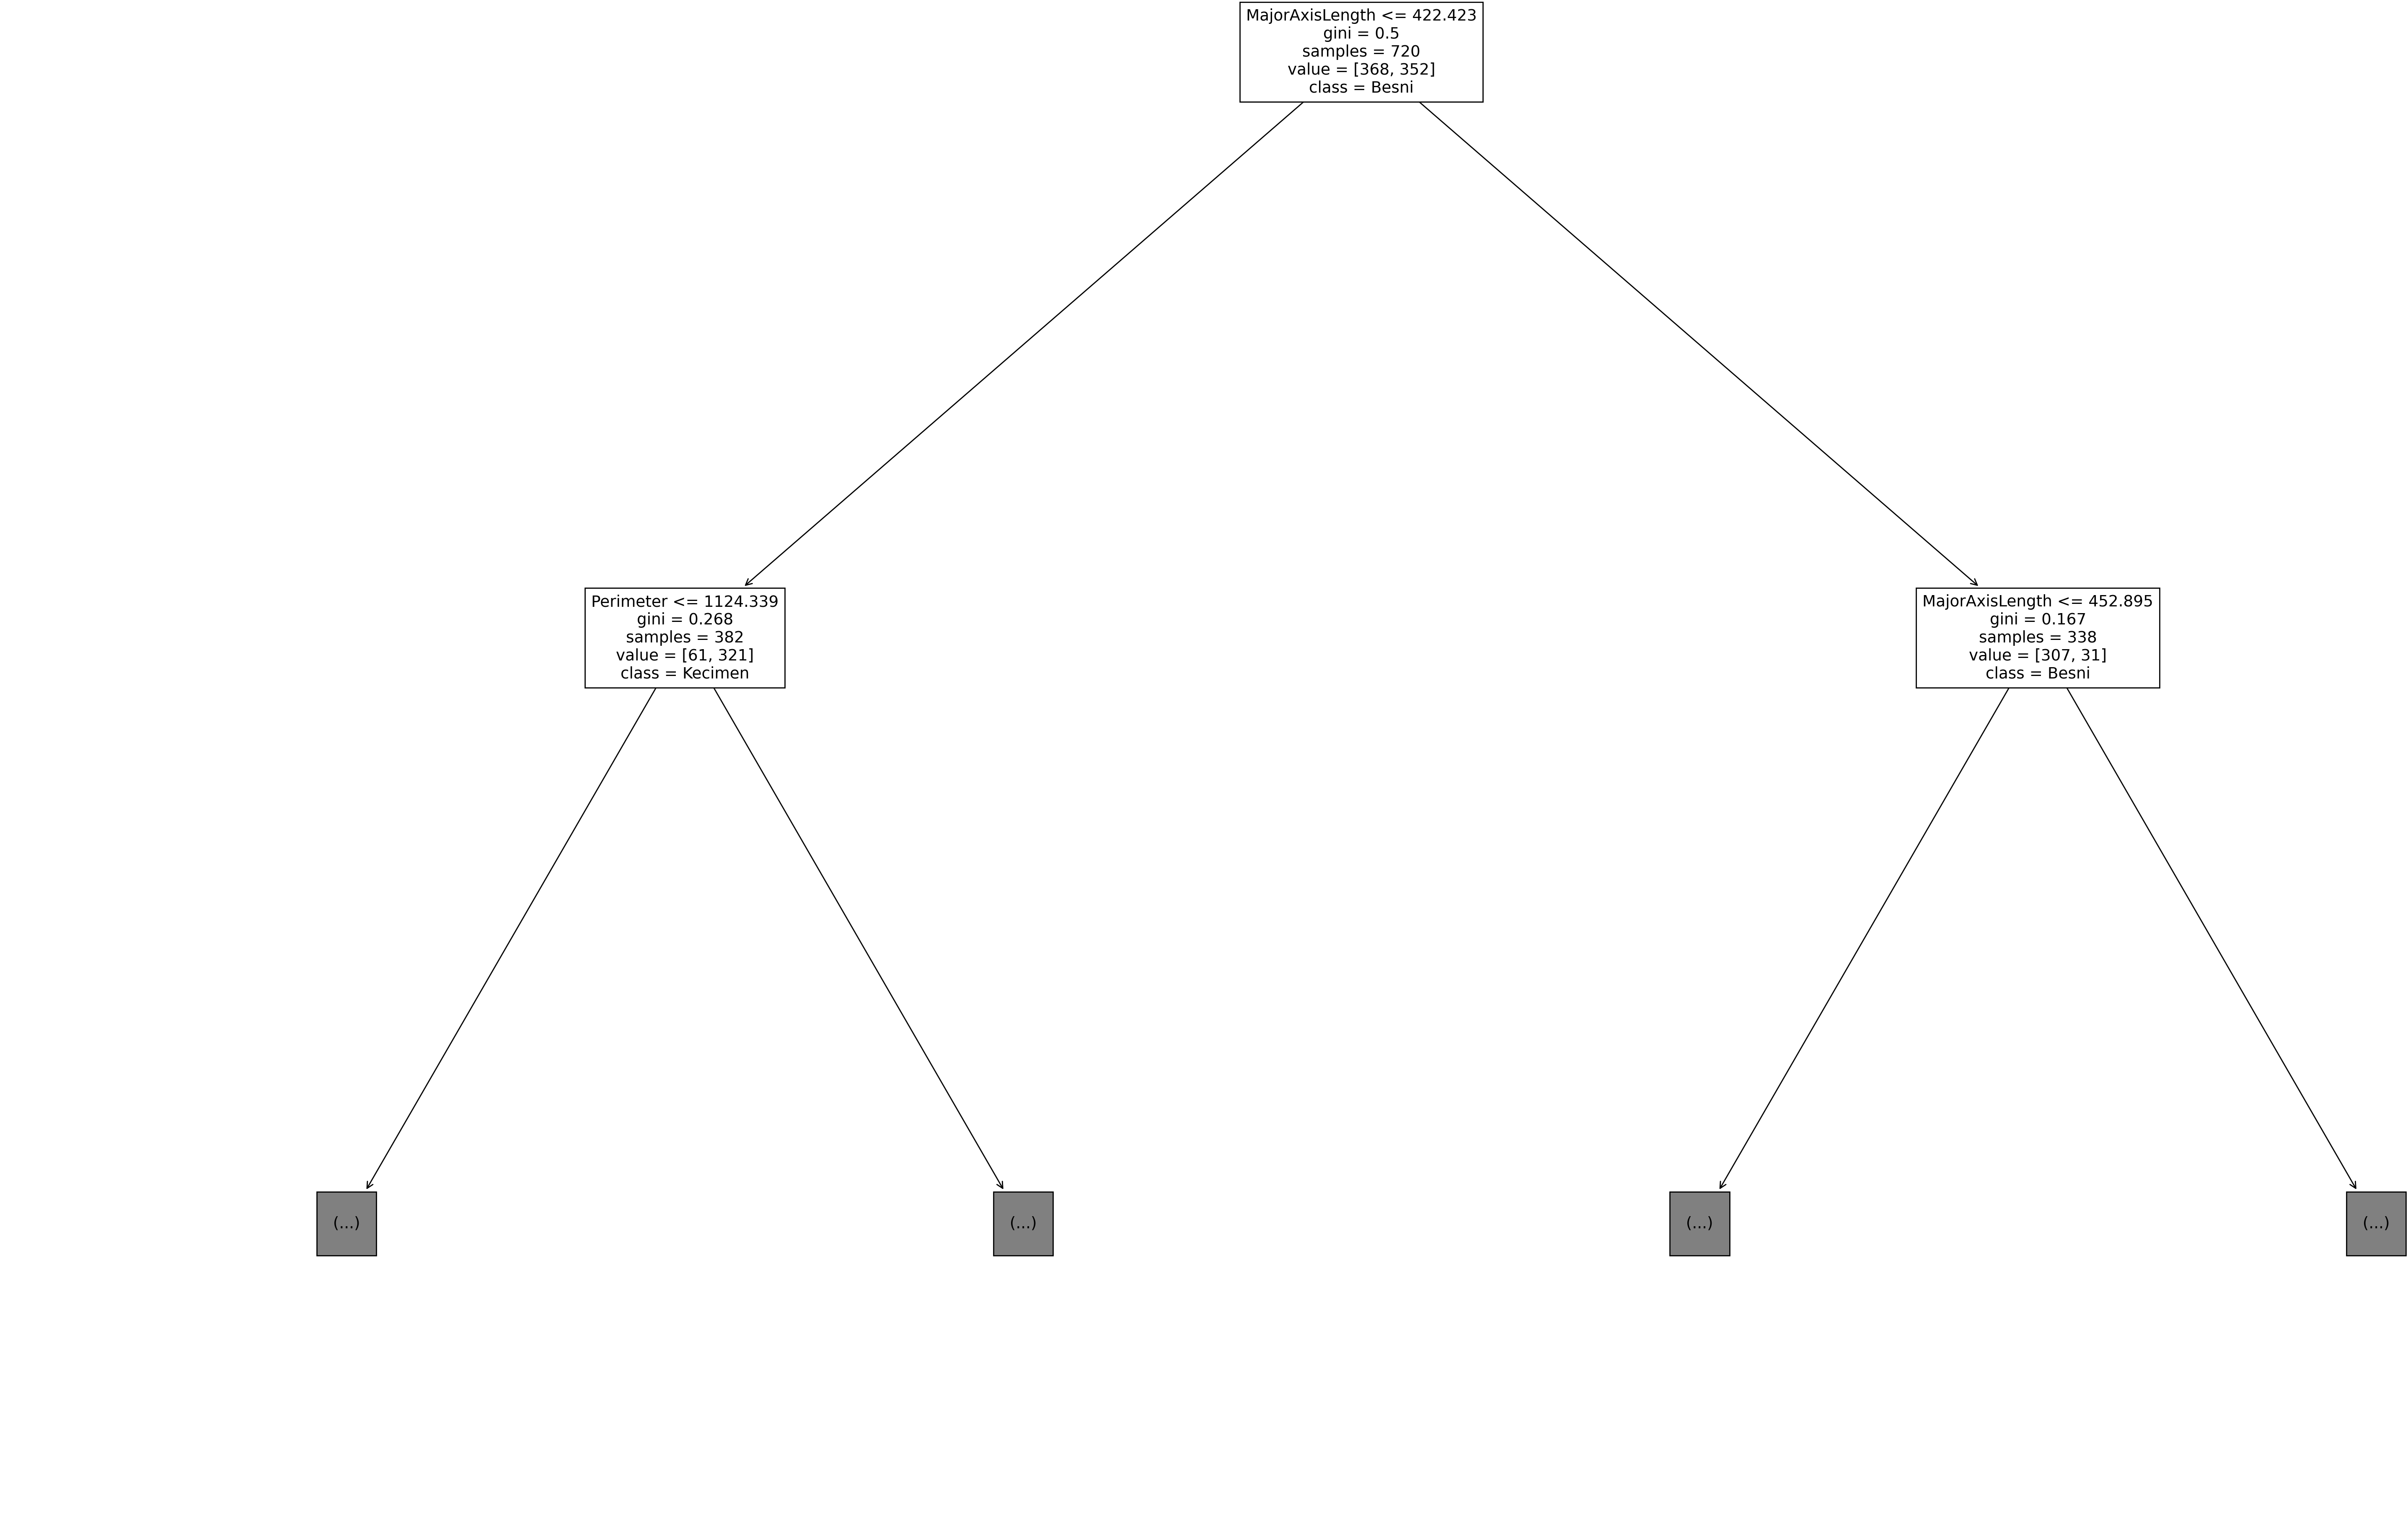

In [132]:
arbol_raisin_4 = DecisionTreeClassifier(max_depth=5,min_samples_split=2)
arbol_raisin_4.fit(X_train.values,y_train)
fig, ax = plt.subplots(1,1, figsize = (15,10), dpi = 200)
arbol_raisin_graph = tree.plot_tree(arbol_raisin_4,
               feature_names = list(X.columns.values), 
               class_names=["Besni", "Kecimen"],
               max_depth=1)

In [133]:
arbol_raisin_graph

[Text(1162.5, 1258.3333333333333, 'MajorAxisLength <= 422.423\ngini = 0.5\nsamples = 720\nvalue = [368, 352]\nclass = Besni'),
 Text(581.25, 755.0, 'Perimeter <= 1124.339\ngini = 0.268\nsamples = 382\nvalue = [61, 321]\nclass = Kecimen'),
 Text(290.625, 251.66666666666674, '\n  (...)  \n'),
 Text(871.875, 251.66666666666674, '\n  (...)  \n'),
 Text(1743.75, 755.0, 'MajorAxisLength <= 452.895\ngini = 0.167\nsamples = 338\nvalue = [307, 31]\nclass = Besni'),
 Text(1453.125, 251.66666666666674, '\n  (...)  \n'),
 Text(2034.375, 251.66666666666674, '\n  (...)  \n')]

Como el árbol quedó profundo, lo he cortado para ver la parte inicial del mismo. Con este corte tenemos dos reglas base, que son las que imprimí en la celda anterior.
- `MajorAxisLength<422.423` y `Perimeter'<1124.339` -> Clase `Kecimen`.
- `MajorAxisLength>422.423` y `MajorAxisLength<452.895` -> Clase `Besni`.

En la tarea anterior, obtuvimos un resultado para el mejor modelo con KNN:

A esto le agregamos las métricas del mejor modelo obtenido con Árboles de Decisión para esta Tarea.

In [131]:
metricas_mejor_KNN=pd.DataFrame({
    'Modelo':['Mejor KNN'],
    'Precisión Global':[0.875556],
    'Error Global':[0.124444],
    'Precisión Positiva (PP)':[0.842975],
    'Precisión Negativa (PN)':[0.913462],
    'Proporción de Falsos Positivos (PFP)':[0.086538],
    'Proporción de Falsos Negativos (PFN)':[0.157025],
    'Asertividad Positiva (AP)':[0.918919],
    'Asertividad Negativa (AN)':[0.833333]
})

arbol_raisin_3 = DecisionTreeClassifier(max_depth=5,min_samples_split=2)
arbol_raisin_3.fit(X_train.values,y_train)
prediccion_raisin_3 = arbol_raisin_3.predict(X_test.values)
### Indices Generales
MC_raisin_3 = confusion_matrix(y_test, prediccion_raisin_3)
indices = indices_general(MC_raisin_3,list(np.unique(y)))
medidas2= MatConf(indices['Matriz de Confusión']).dict_medidas
df2=pd.DataFrame({'Modelo':['Mejor AD']})
for key in list(medidas2.keys()):
    df2[key]=medidas2[key]
metricas_mejor_KNN= metricas_mejor_KNN.append(df2)
metricas_mejor_KNN

,Modelo,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
0,Mejor KNN,0.875556,0.124444,0.842975,0.913462,0.086538,0.157025,0.918919,0.833333
0,Mejor AD,0.861111,0.138889,0.908163,0.804878,0.195122,0.091837,0.847619,0.880000


El modelo KNN parece ser mejor que el modelo AD (Árbol de Decisión) obtenido sobre estos datos.

<div class='question_container'>
    <h2> Pregunta 5 </h2>
    <p> En este ejercicio usaremos la tabla de datos abandono clientes.csv, que contiene los detalles de los clientes de un banco. </p>
    <p> La tabla contiene 11 columnas (variables), las cuales se explican a continuación. </p>
    <ul>
        <li> <span class='code_span'> CreditScore </span>: Indica el puntaje de crédito. </li>
        <li> <span class='code_span'>Geography</span>: País al que pertenece.</li>
        <li> <span class='code_span'>Gender</span>: Género del empleado.</li>
        <li> <span class='code_span'>Age</span>: Edad del empleado.</li>
        <li> <span class='code_span'>Tenure</span>: El tiempo del vínculo con la empresa.</li>
        <li> <span class='code_span'>Balance</span>: La cantidad que les queda.</li>
        <li> <span class='code_span'>NumOfProducts</span>: Los productos que posee.</li>
        <li> <span class='code_span'>HasCrCard</span>: Tienen tarjeta de crédito o no.</li>
        <li> <span class='code_span'>IsActiveMember</span>: Es un miembro activo o no.</li>
        <li> <span class='code_span'>EstimatedSalary</span>: Salario estimado.</li>
        <li> <span class='code_span'>Exited</span>: Indica si el cliente se queda o se va.</li>
    </ul>
    <p> Realice lo siguiente: </p>
    <ol>
        <li> Cargue en <span class='code_span'>Python</span> la tabla de datos <span class='code_span'>abandono_clientes.csv</span>. </li>
        <li> Use el método de Árboles de Decisión en Python para generar un modelo predictivo para la tabla abandono clientes.csv usando el 75% de los datos para la tabla aprendizaje y un 25% para la tabla testing.Use los mejores parámetros que pueda identificar. </li>
        <li> Grafique el árbol generado e interprete al menos dos reglas que se puedan extraer del mismo. Si es necesario pode el árbol para que las reglas sean legibles. </li>
        <li> Genere de nuevo un modelo predictivo con el método de Árboles de decisión pero esta vez utilice selección de 6 variables. ¿Mejora el resultado respecto al modelo generado con todas las variables? </li>
        <li> Construya un <span class='code_span'>DataFrame</span> que compare el mejor modelo de árboles construido arriba con el mejor modelo construido en la tarea anterior para la tabla <span class='code_span'>abandono_clientes.csv</span>. Para esto en cada una de las filas debe aparecer un modelo predictivo y en las columnas aparezcan los índices Precisión Global, Error Global, Precisión Positiva (PP) y Precisión Negativa (PN). ¿Cuál de los modelos es mejor para estos datos? Guarde los datos de este DataFrame, ya que se irá modificando en próximas tareas. </li>
    </ol>
</div>

In [154]:
# Leemos los datos

df_clientes = pd.read_csv("abandono_clientes.csv")
df_clientes = df_clientes.drop(['Unnamed: 0'], axis=1)

# Convierte las variables a categórica
columnas_cat= [col for col in df_clientes.columns if str(df_clientes.dtypes[col]) =='object' and col!='Exited' ] ### Columnas predictivas y string
for col in columnas_cat:
    df_clientes[col] = df_clientes[col].astype('category')
    
# Variable a predecir
y = df_clientes["Exited"].ravel()

#Convertimos a Dummy algunas de las variables predictoras
X = pd.get_dummies(df_clientes.drop(columns=["Exited"]), columns=columnas_cat)

X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_No,HasCrCard_Si,IsActiveMember_No,IsActiveMember_Si
0,619,42,2,0.00,1,101348.88,1,0,0,1,0,0,1,0,1
1,608,41,1,83807.86,1,112542.58,0,0,1,1,0,1,0,0,1
2,502,42,8,159660.80,3,113931.57,1,0,0,1,0,0,1,1,0
3,699,39,1,0.00,2,93826.63,1,0,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,79084.10,0,0,1,1,0,0,1,0,1


In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.75)

In [156]:
### Vamos a hacer la malla como en la pregunta anterior para encontrar los mejores parámetros posibles.

arboles_decision=pd.DataFrame({
    'max_depth':[],
    'min_samples_split':[],
    'prec_glob':[],
    'err_glob':[],
    'prec_No':[],
    'prec_Si':[]
})

max_depths=range(5,10) ### max_depths de 2 a 20
min_samples_splits= range(2,31) ### min_samples_split de 2 a 20.

start=time.time()
for md in max_depths:
    for mss in min_samples_splits:
        arbol_clientes_3 = DecisionTreeClassifier(max_depth=md,min_samples_split=mss)
        arbol_clientes_3.fit(X_train.values,y_train)
        prediccion_clientes_3 = arbol_clientes_3.predict(X_test.values)
        ### Indices Generales
        MC_clientes_3 = confusion_matrix(y_test, prediccion_clientes_3)
        indices = indices_general(MC_clientes_3,list(np.unique(y)))
        arboles_decision=arboles_decision.append(
            pd.DataFrame({
                'max_depth':[md],
                'min_samples_split':[mss],
                'prec_glob':[indices['Precisión Global']],
                'err_glob':[indices['Error Global']],
                'prec_No':[indices['Precisión por categoría']['No'][0]],
                'prec_Si':[indices['Precisión por categoría']['Si'][0]]
            }), ignore_index=True)
end=time.time()
print(f"Calculo de Arboles de Decision con la malla duró {end-start} segundos.")
### Modelos con mejor precisión global al inicio
arboles_decision=arboles_decision.sort_values(by=['prec_glob'], ascending=False)
arboles_decision.head(10)

Calculo de Arboles de Decision con la malla duró 2.498180389404297 segundos.


,max_depth,min_samples_split,prec_glob,err_glob,prec_No,prec_Si
0,5.0,2.0,0.861004,0.138996,0.985728,0.32377
5,5.0,7.0,0.861004,0.138996,0.985728,0.32377
7,5.0,9.0,0.861004,0.138996,0.985728,0.32377
6,5.0,8.0,0.861004,0.138996,0.985728,0.32377
1,5.0,3.0,0.861004,0.138996,0.985728,0.32377
4,5.0,6.0,0.861004,0.138996,0.985728,0.32377
2,5.0,4.0,0.861004,0.138996,0.985728,0.32377
3,5.0,5.0,0.861004,0.138996,0.985728,0.32377
15,5.0,17.0,0.860232,0.139768,0.984776,0.32377
21,5.0,23.0,0.860232,0.139768,0.984776,0.32377


Obtuvimos el mejor modelo (en términos de precisión global con `max_depth=5` y `min_samples_split=2`. Siempre tenemos que la precisión en `No` es alta, y en `Si` es baja.

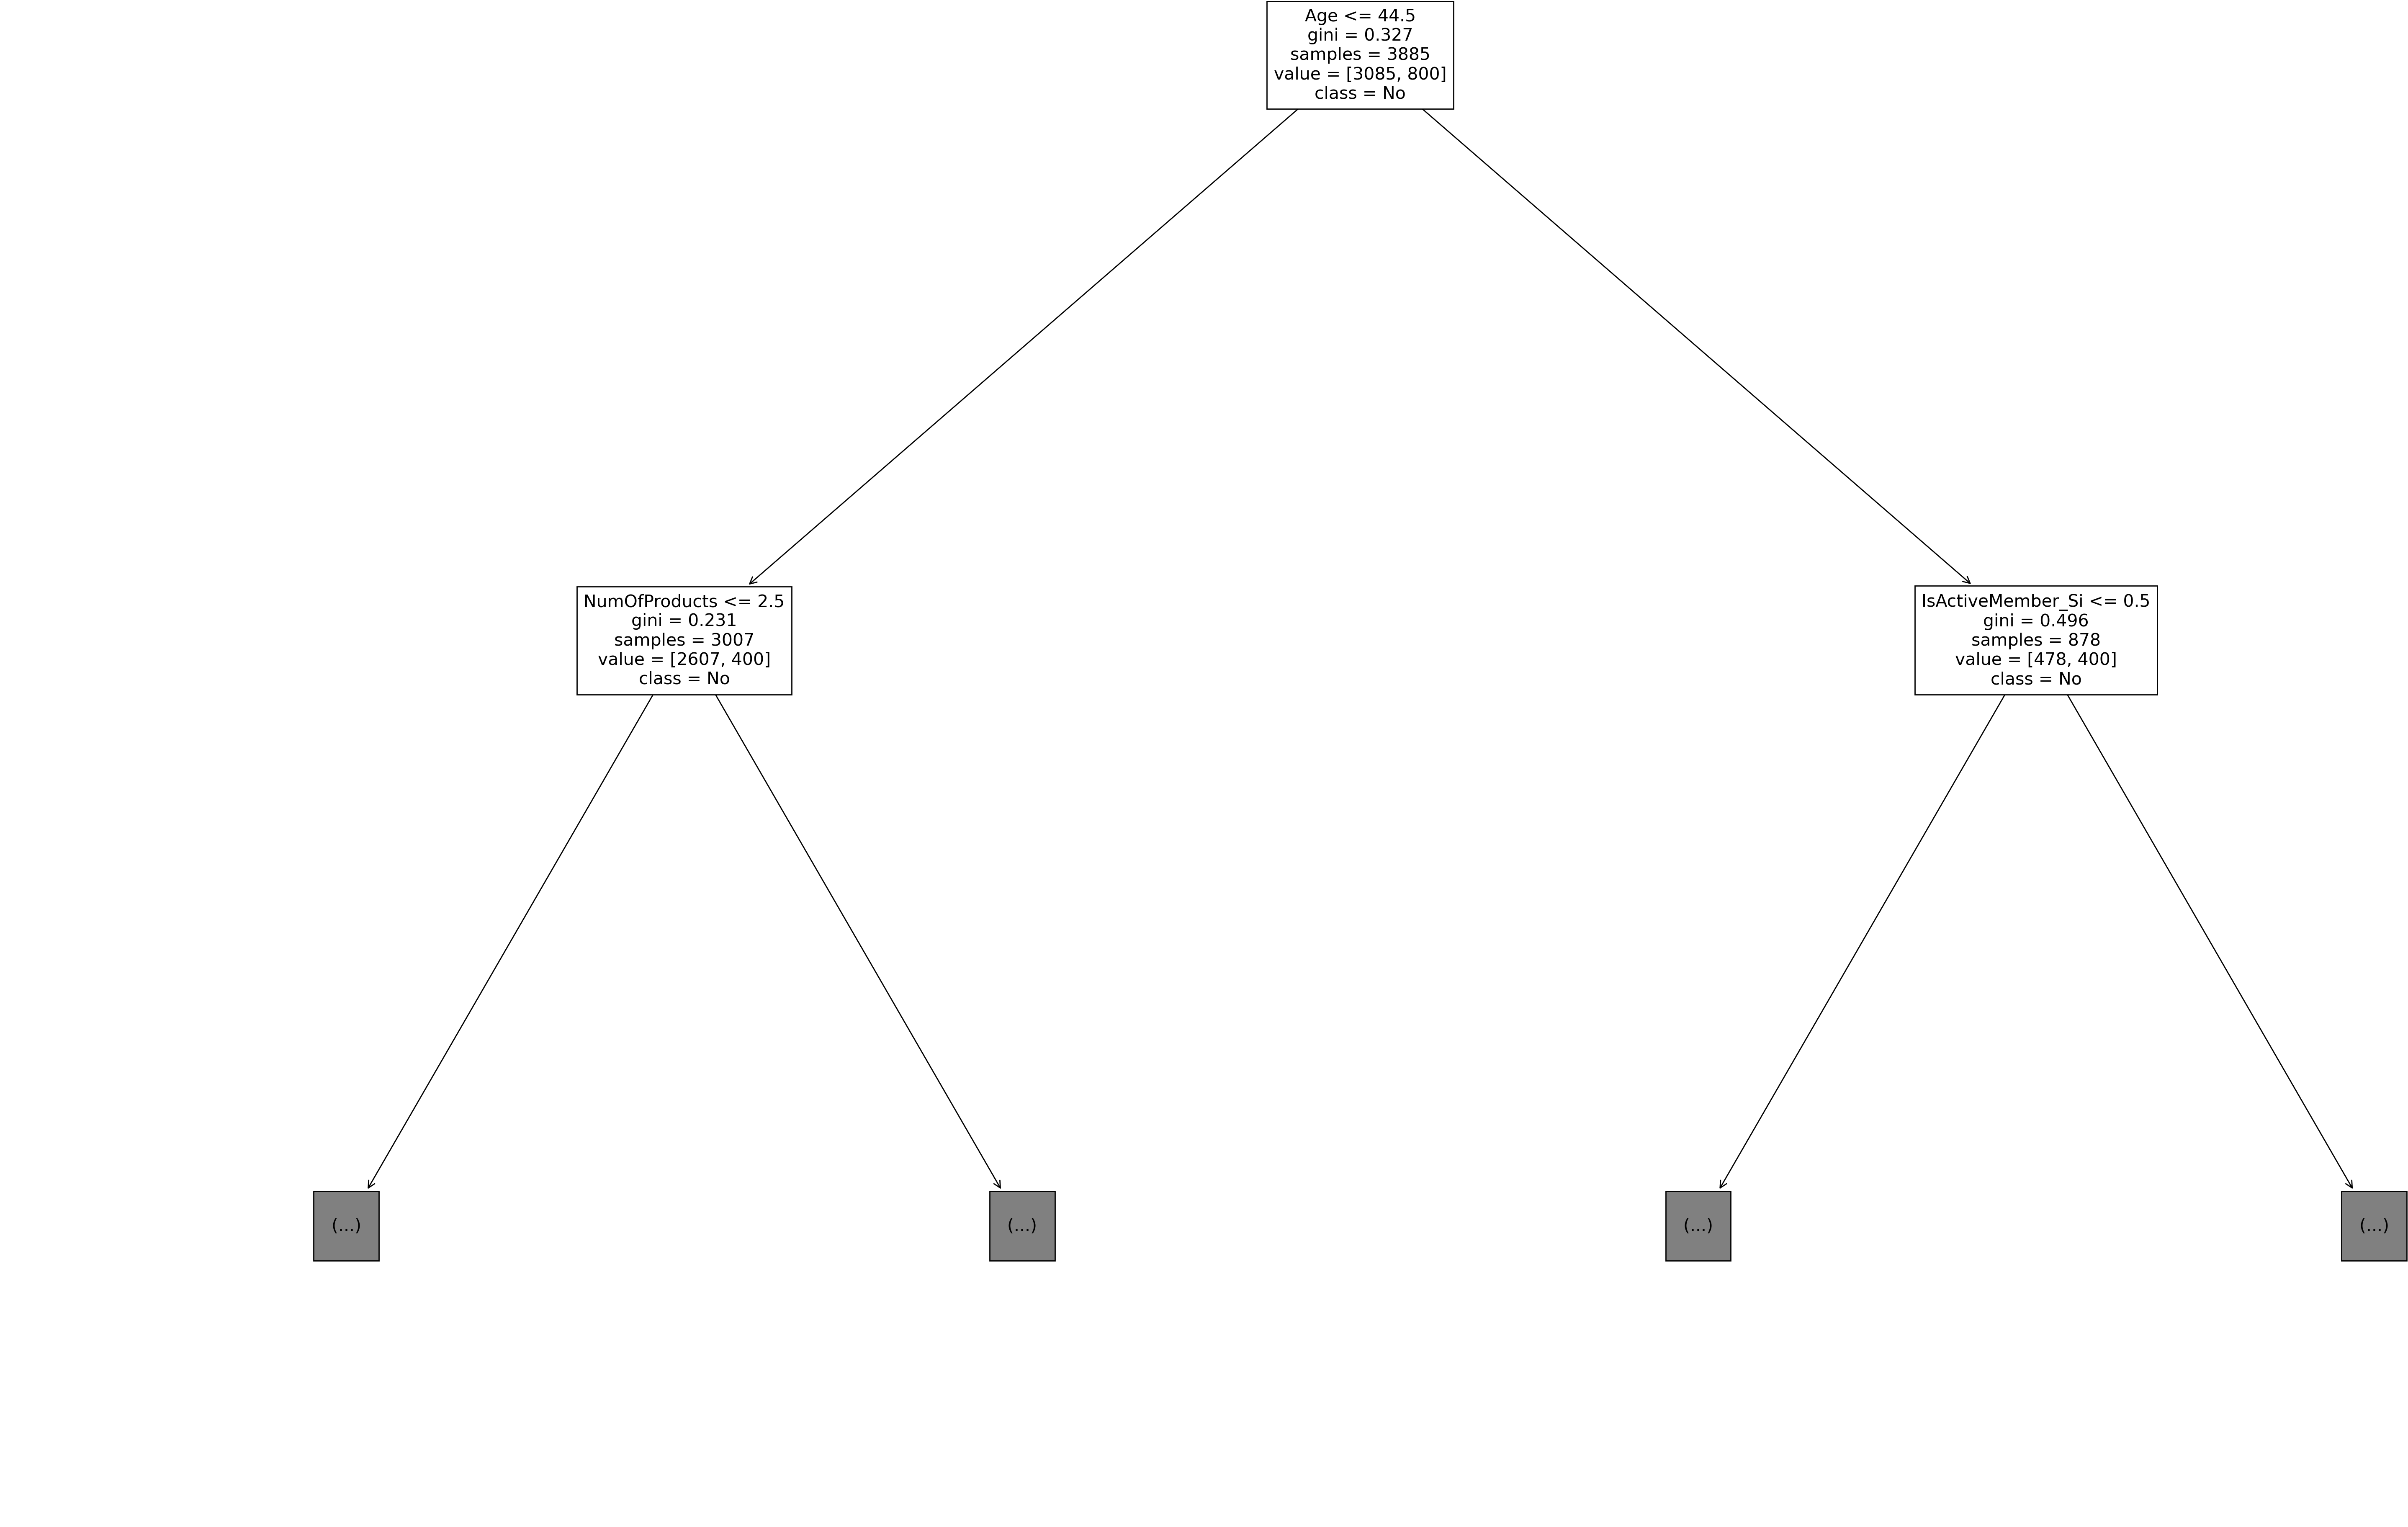

In [157]:
arbol_clientes_5 = DecisionTreeClassifier(max_depth=5,min_samples_split=2)
arbol_clientes_5.fit(X_train.values,y_train)
fig, ax = plt.subplots(1,1, figsize = (15,10), dpi = 200)
arbol_clientes_graph = tree.plot_tree(arbol_clientes_5,
               feature_names = list(X.columns.values), 
               class_names=["No", "Si"],
               max_depth=1)

In [142]:
arbol_clientes_graph

[Text(1162.5, 1258.3333333333333, 'Age <= 42.5\ngini = 0.318\nsamples = 3885\nvalue = [3116, 769]\nclass = No'),
 Text(581.25, 755.0, 'NumOfProducts <= 2.5\ngini = 0.209\nsamples = 2790\nvalue = [2459, 331]\nclass = No'),
 Text(290.625, 251.66666666666674, '\n  (...)  \n'),
 Text(871.875, 251.66666666666674, '\n  (...)  \n'),
 Text(1743.75, 755.0, 'IsActiveMember_Si <= 0.5\ngini = 0.48\nsamples = 1095\nvalue = [657, 438]\nclass = No'),
 Text(1453.125, 251.66666666666674, '\n  (...)  \n'),
 Text(2034.375, 251.66666666666674, '\n  (...)  \n')]

Hemos cortado la profundidad para sólo mostrar los primeros nodos. Algunas reglas (incompletas) que nos muestran estos nodos inciales son:
- `Age<=42.5` y `NumOfProducts<=2.5` -> Clase `No`.
- `Age>42.5` y `IsActiveMember_Si <= 0.5` (lo que es lo mismo `IsActiveMember`=`No` por el dummy encoding) -> Clase `No`.

Seleccionemos variables para ajustar otro modelo, que quizá pueda ser mejor. Veamos los gráficos de poder predictivo de cada variable.

In [158]:
df_clientes.dtypes

CreditScore           int64
Geography          category
Gender             category
Age                   int64
Tenure                int64
Balance             float64
NumOfProducts         int64
HasCrCard          category
IsActiveMember     category
EstimatedSalary     float64
Exited               object
dtype: object

In [159]:
cols_num_clientes=['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
cols_cat_clientes=['Geography','Gender','HasCrCard','IsActiveMember']

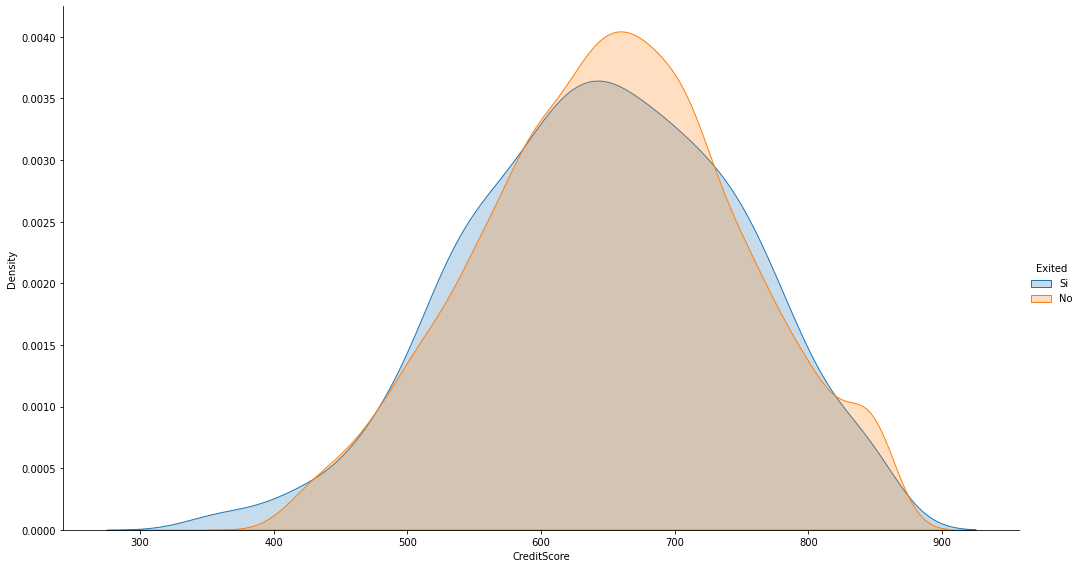

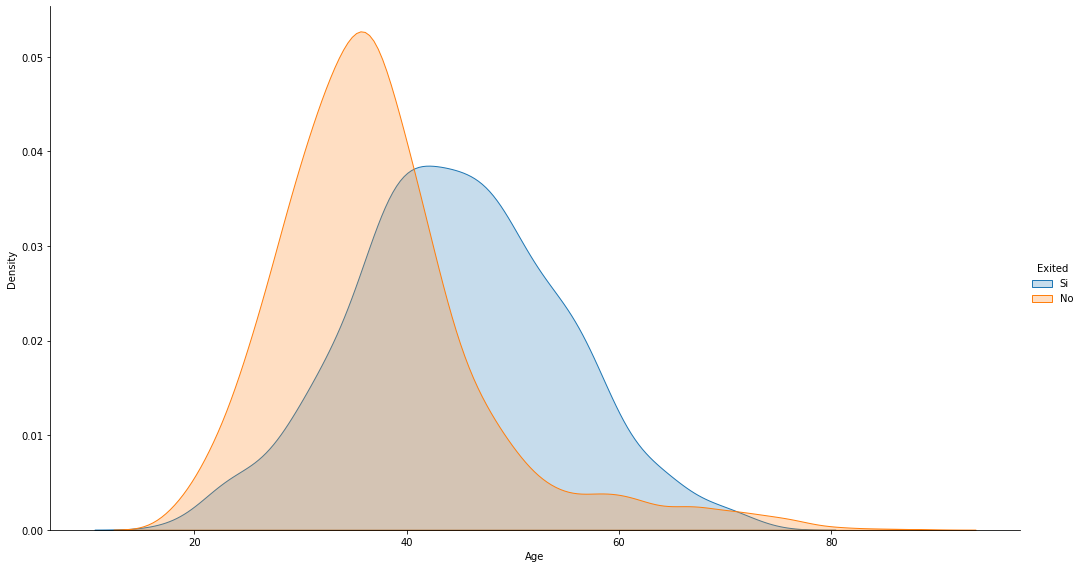

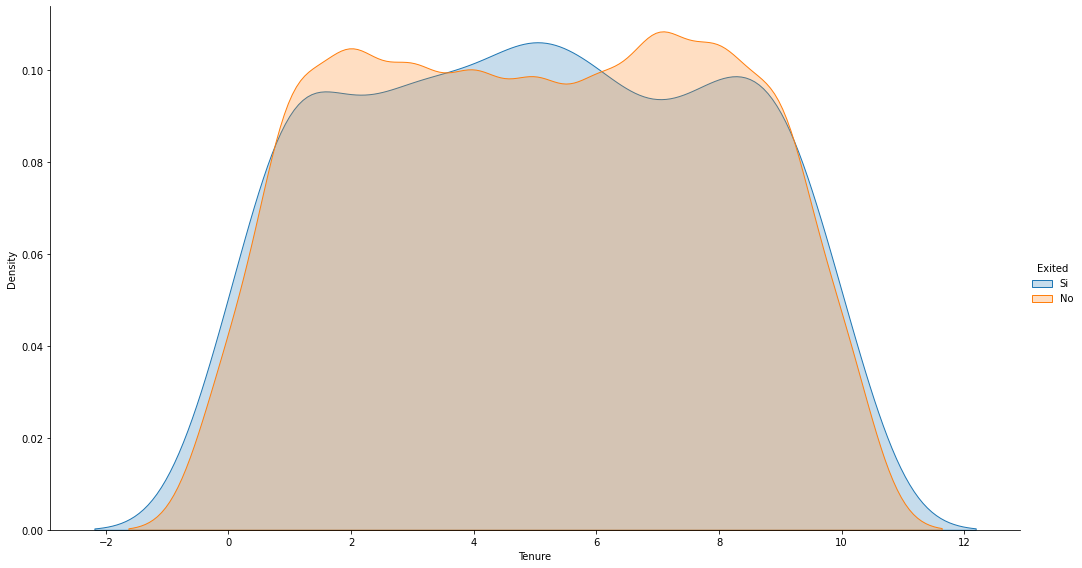

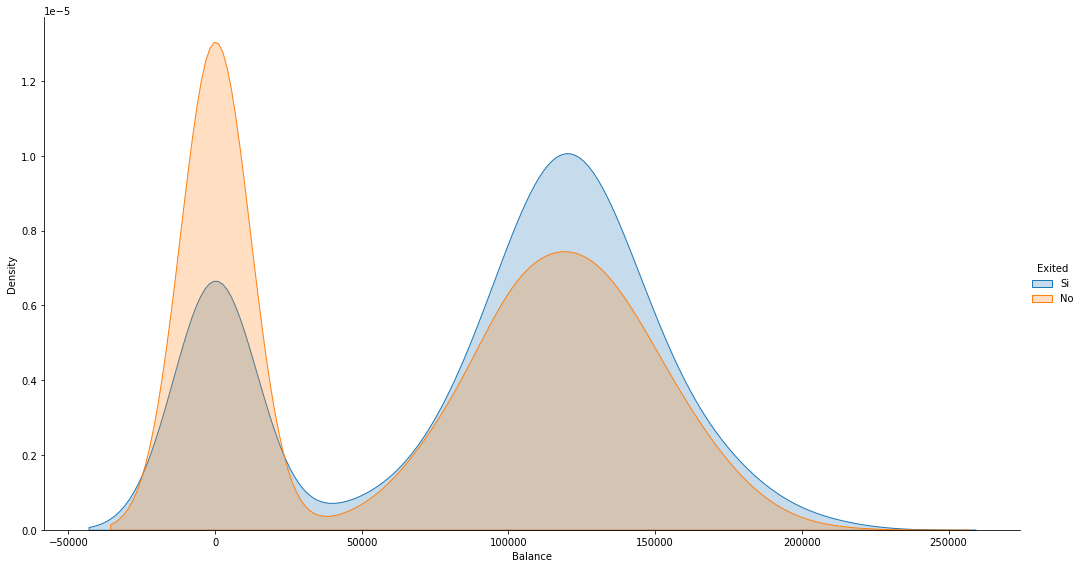

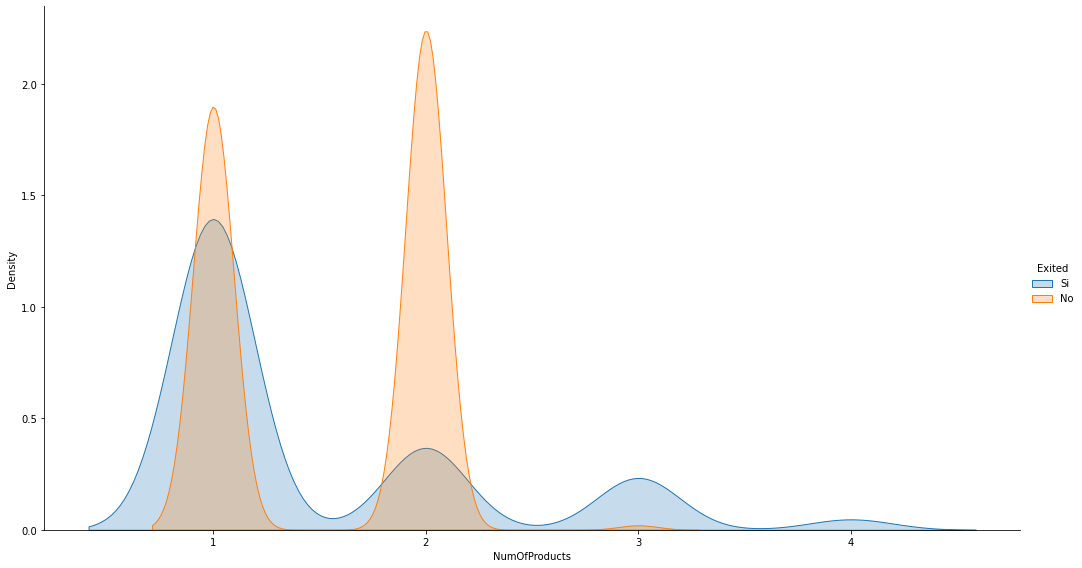

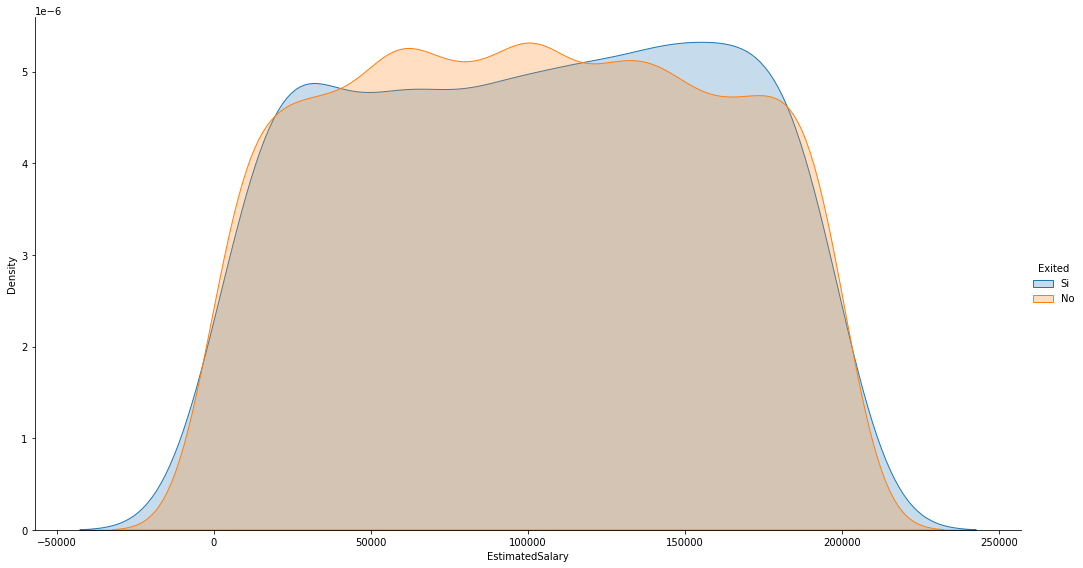

In [160]:
for col in cols_num_clientes:
    poder_predictivo_numerica(df_clientes,col,"Exited")
    plt.show()

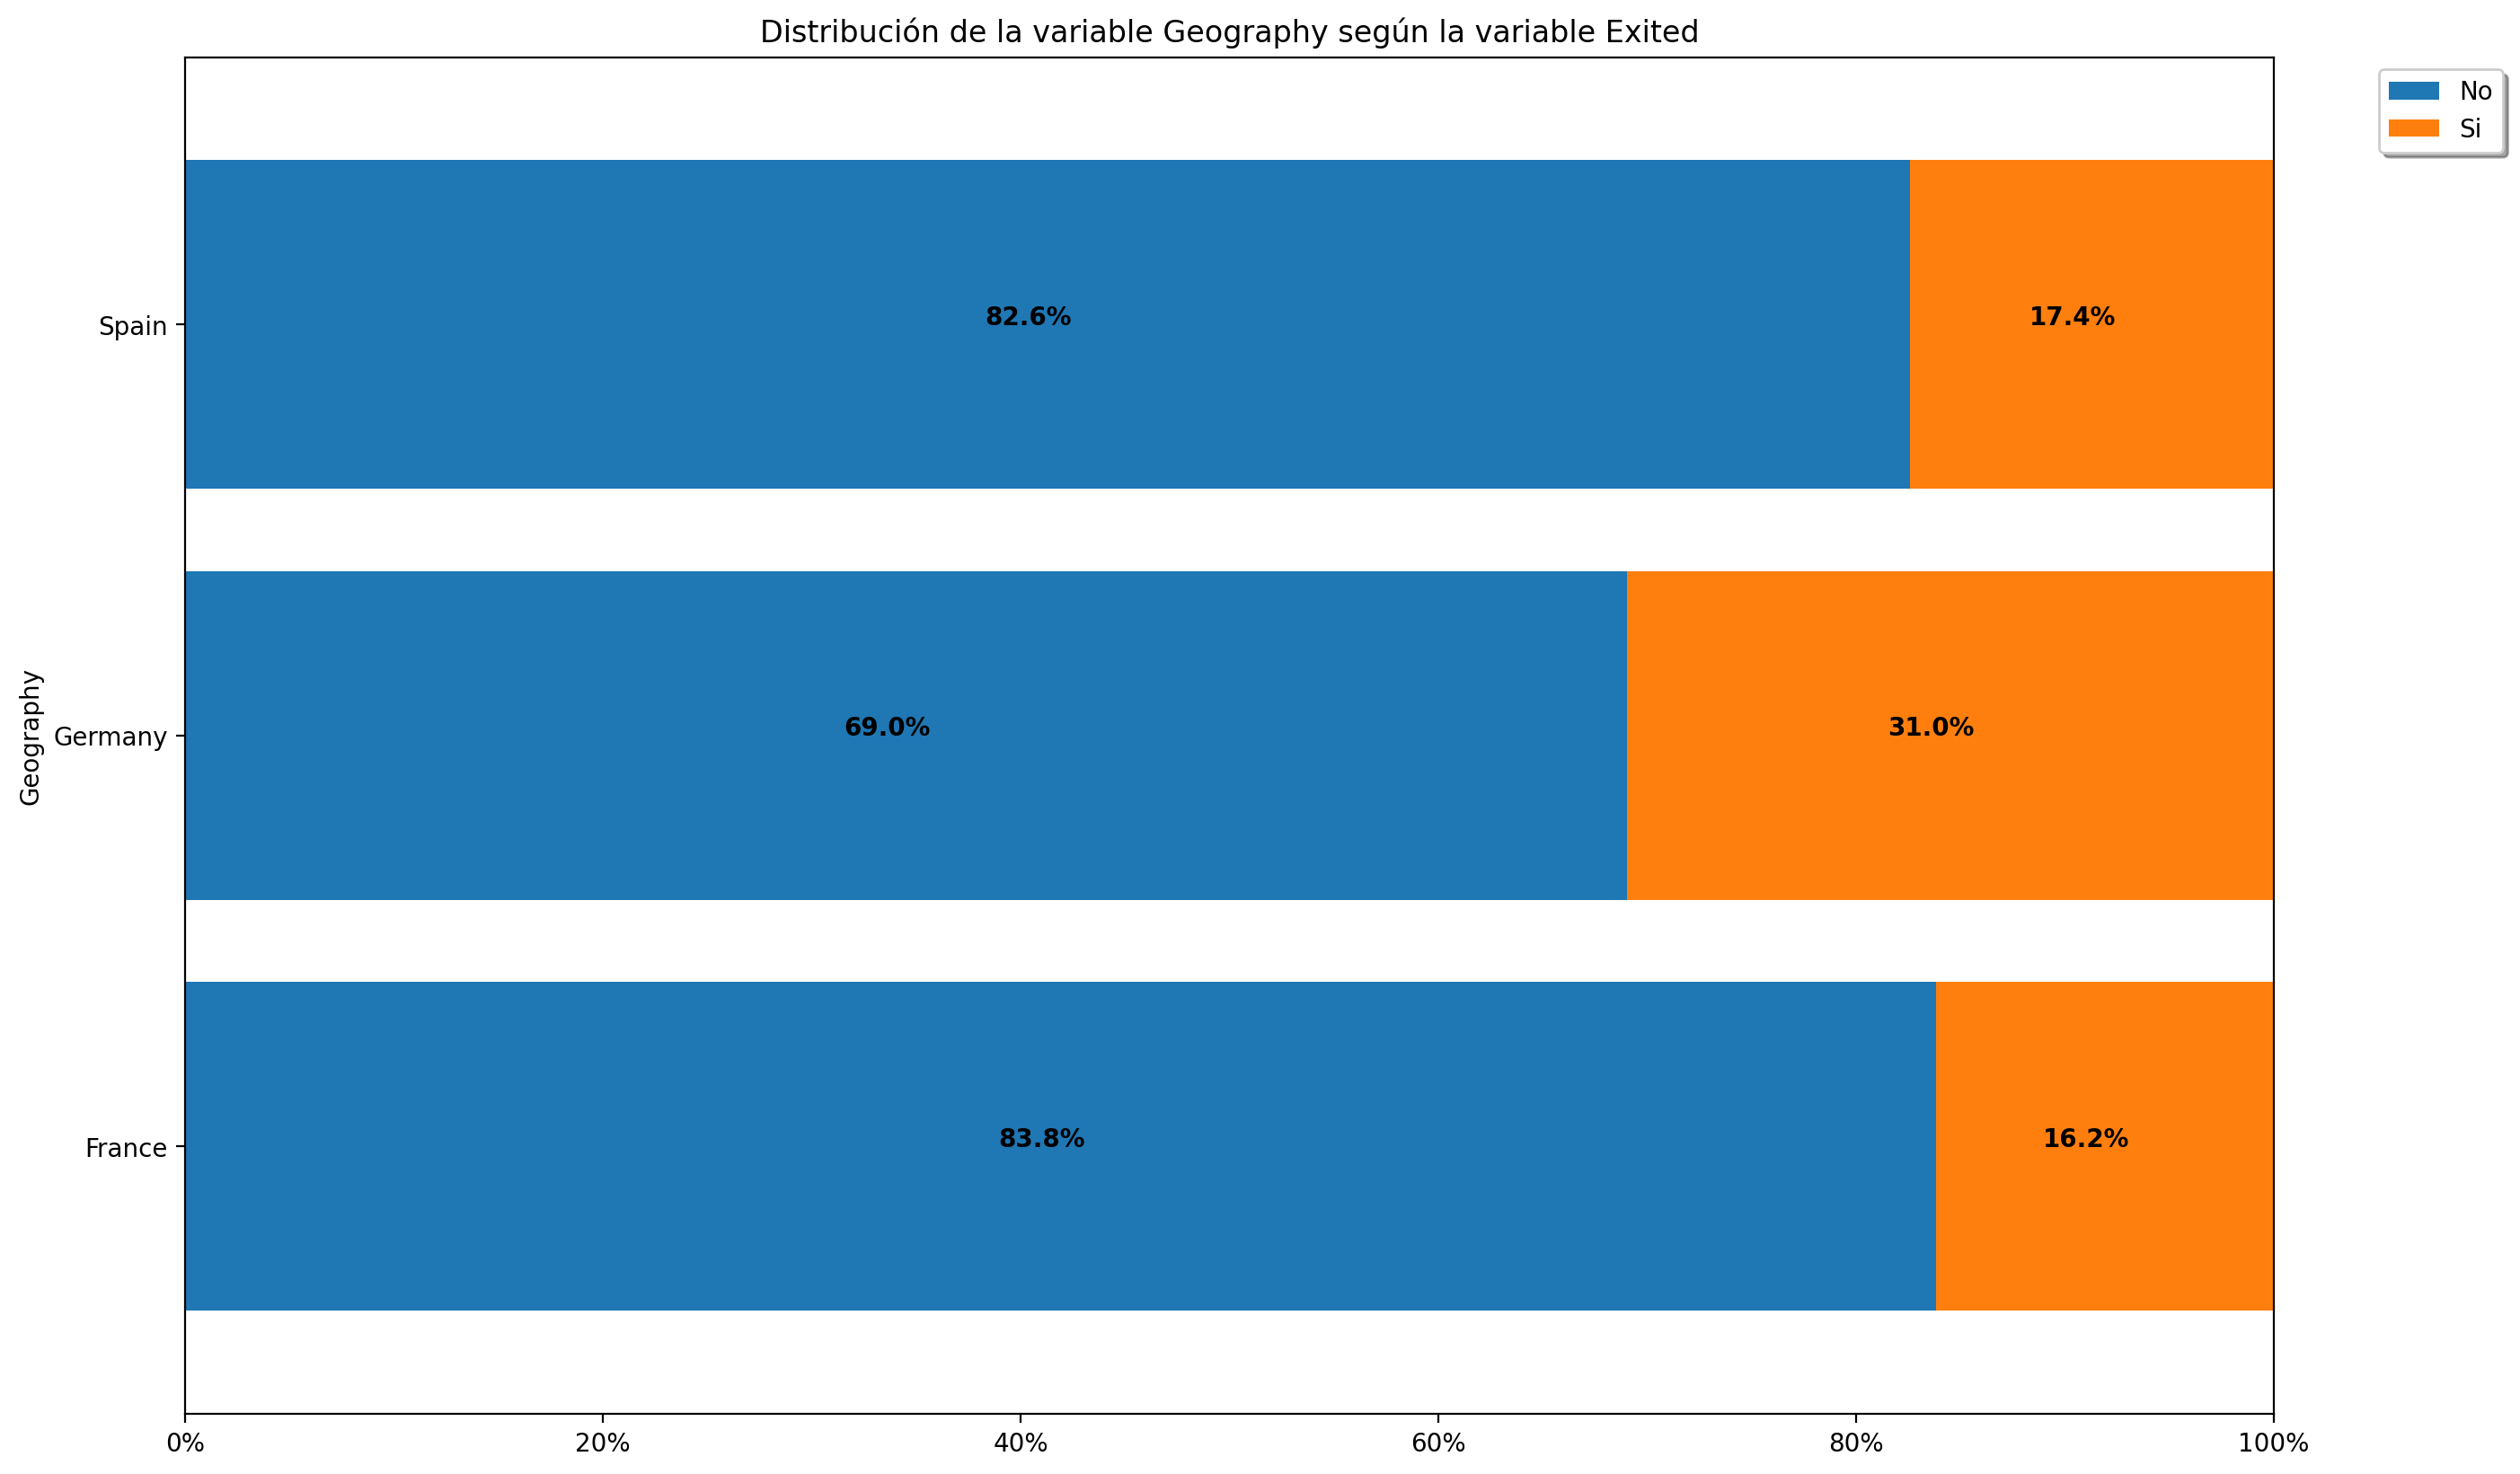

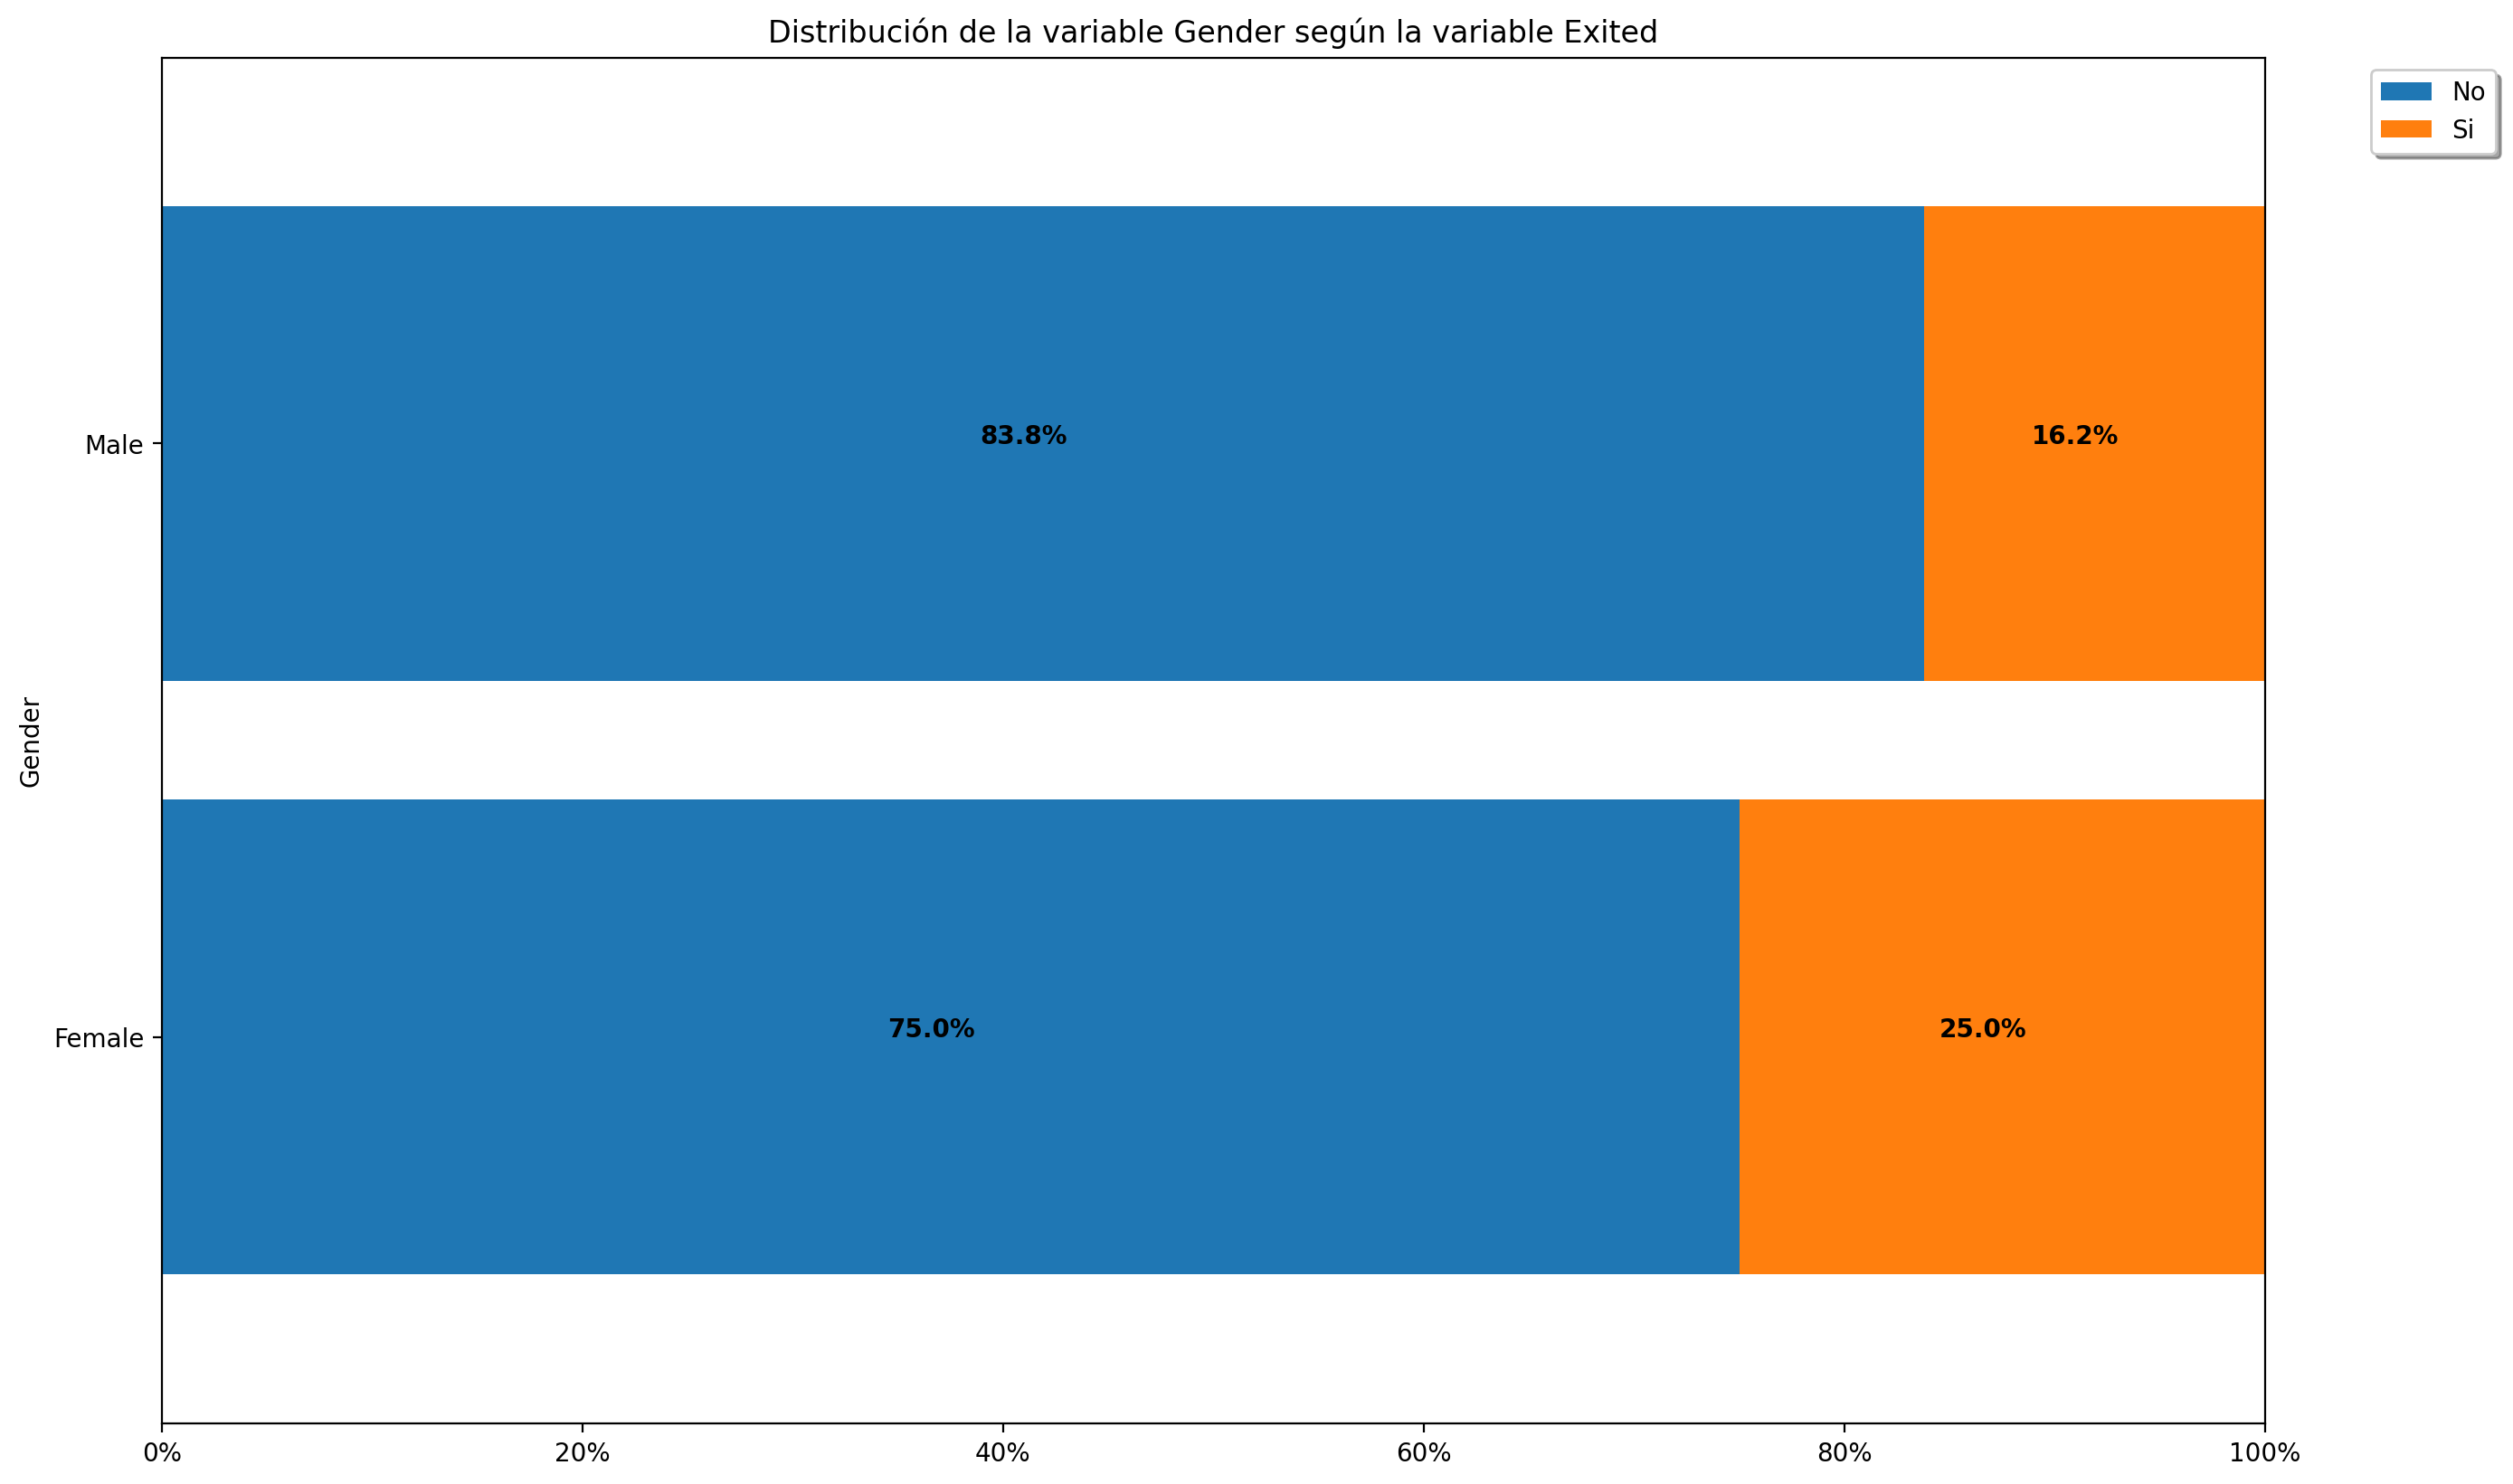

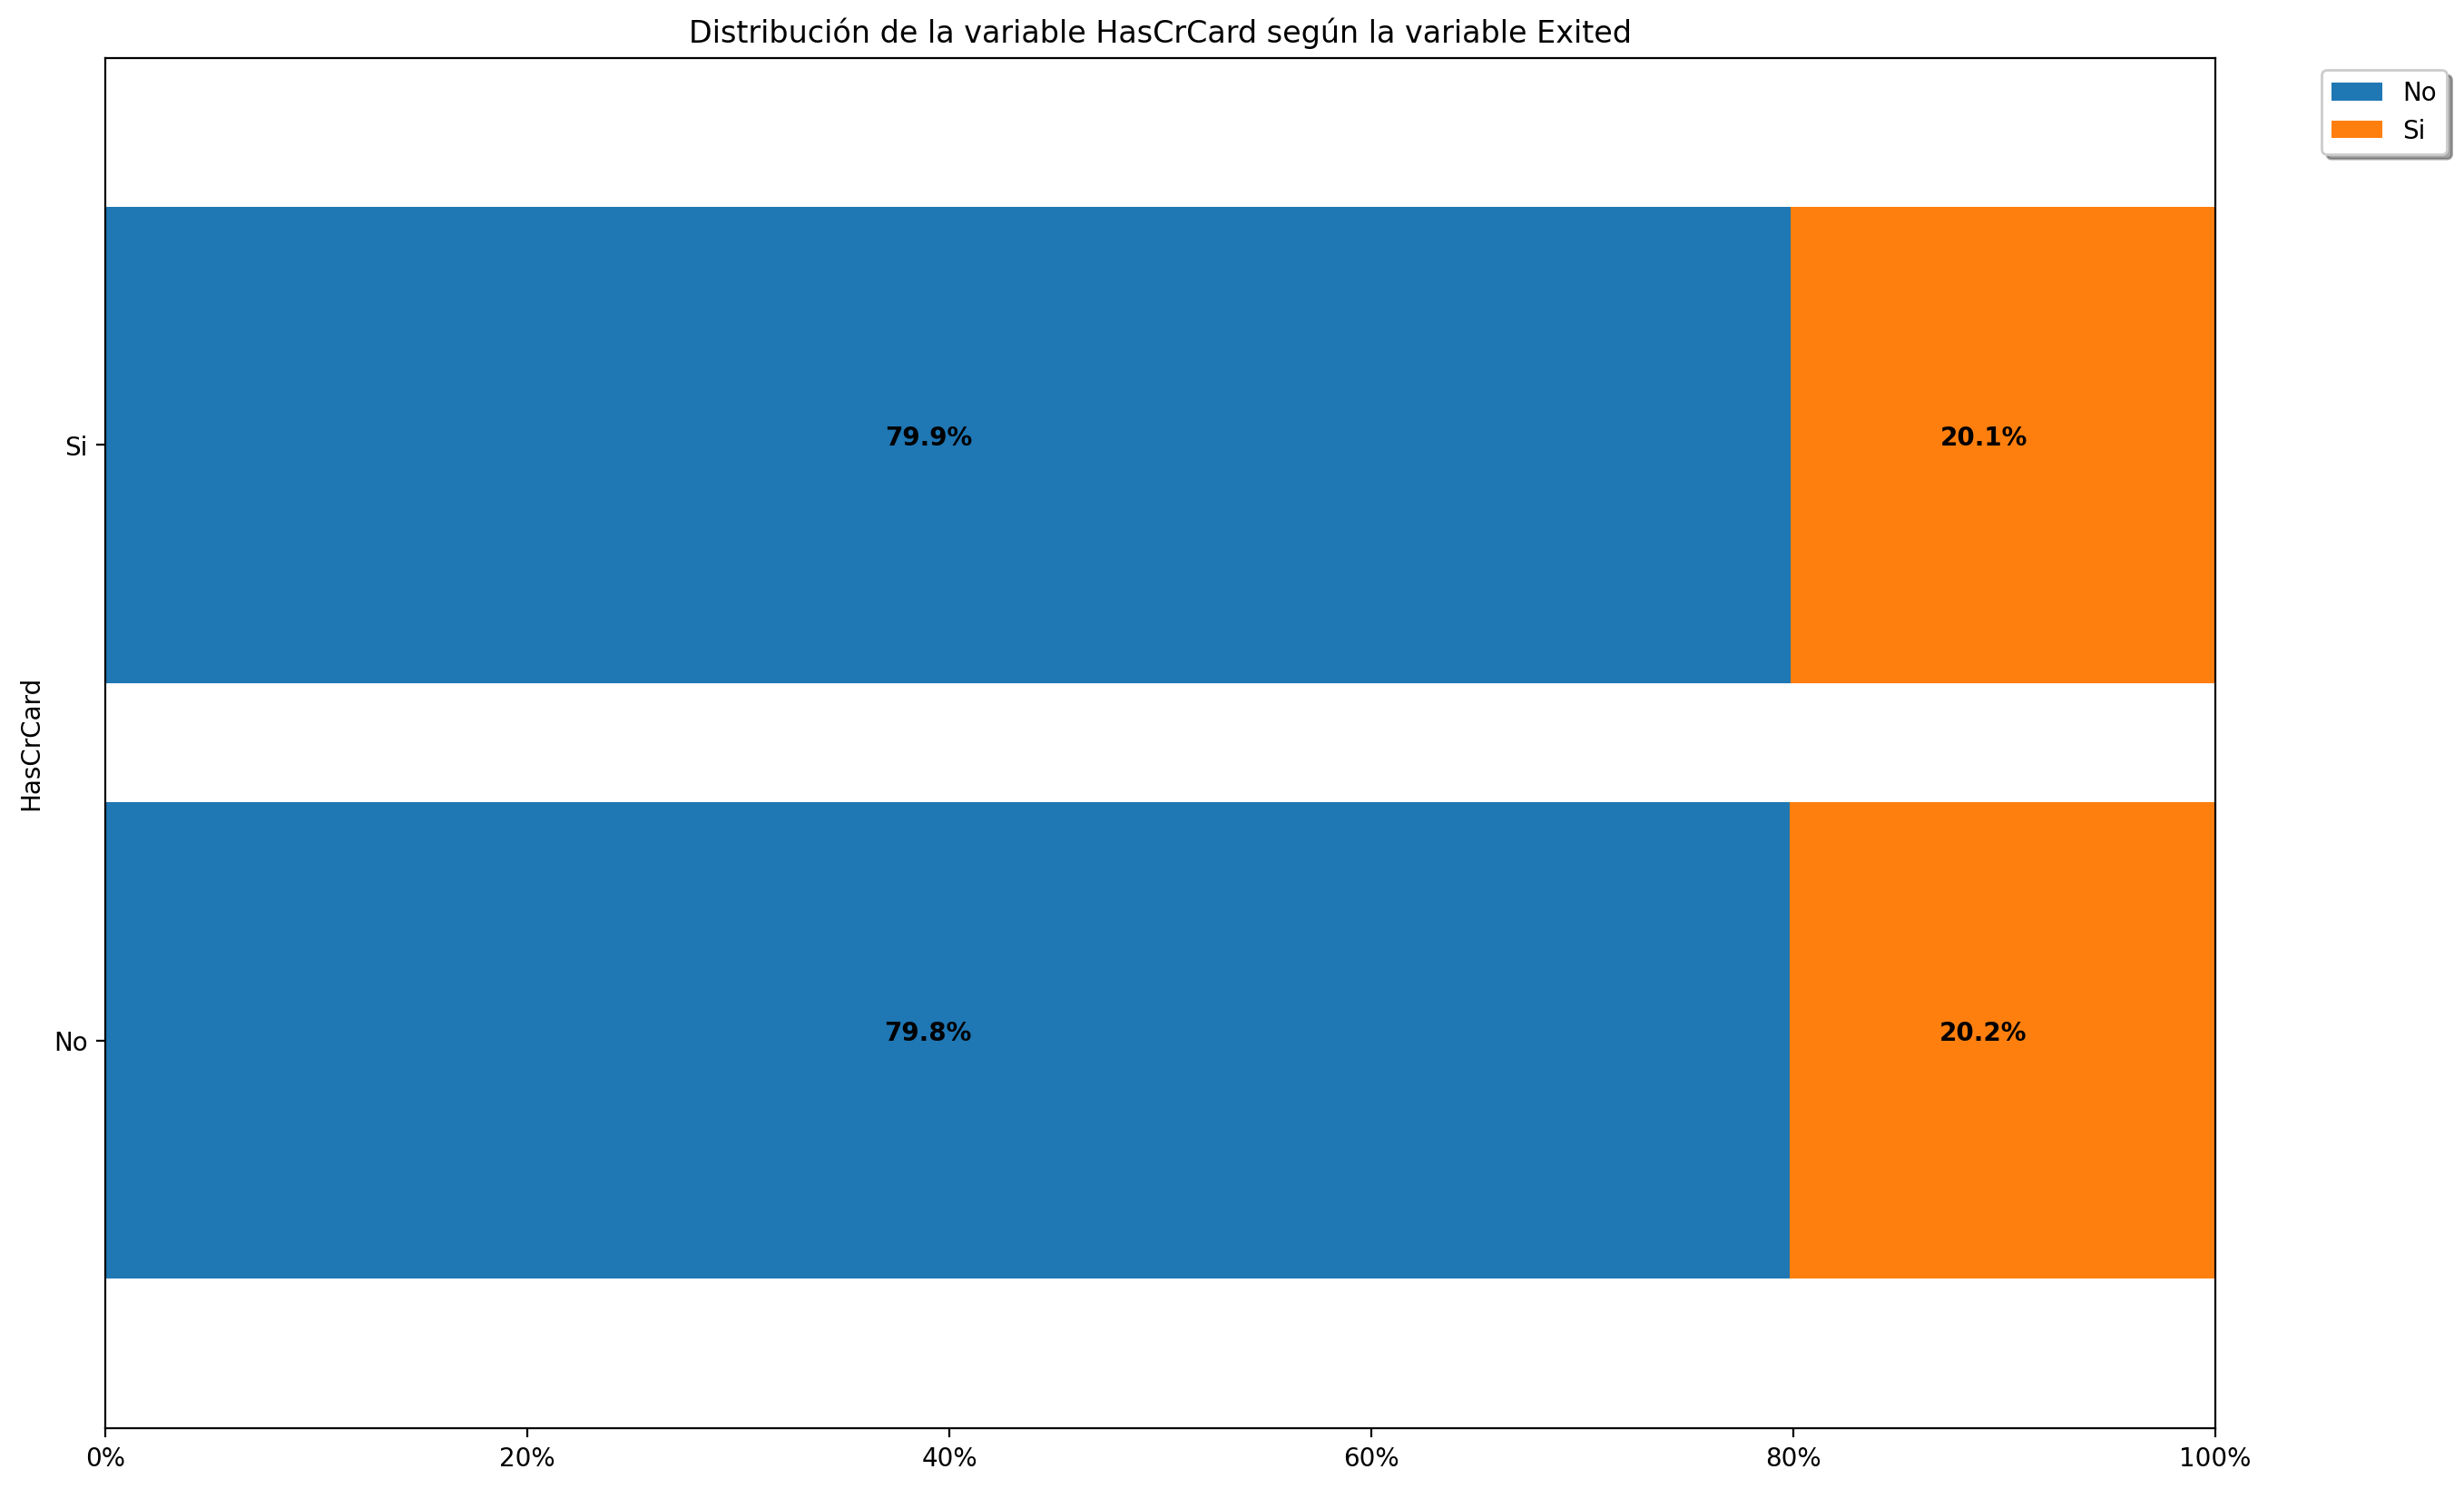

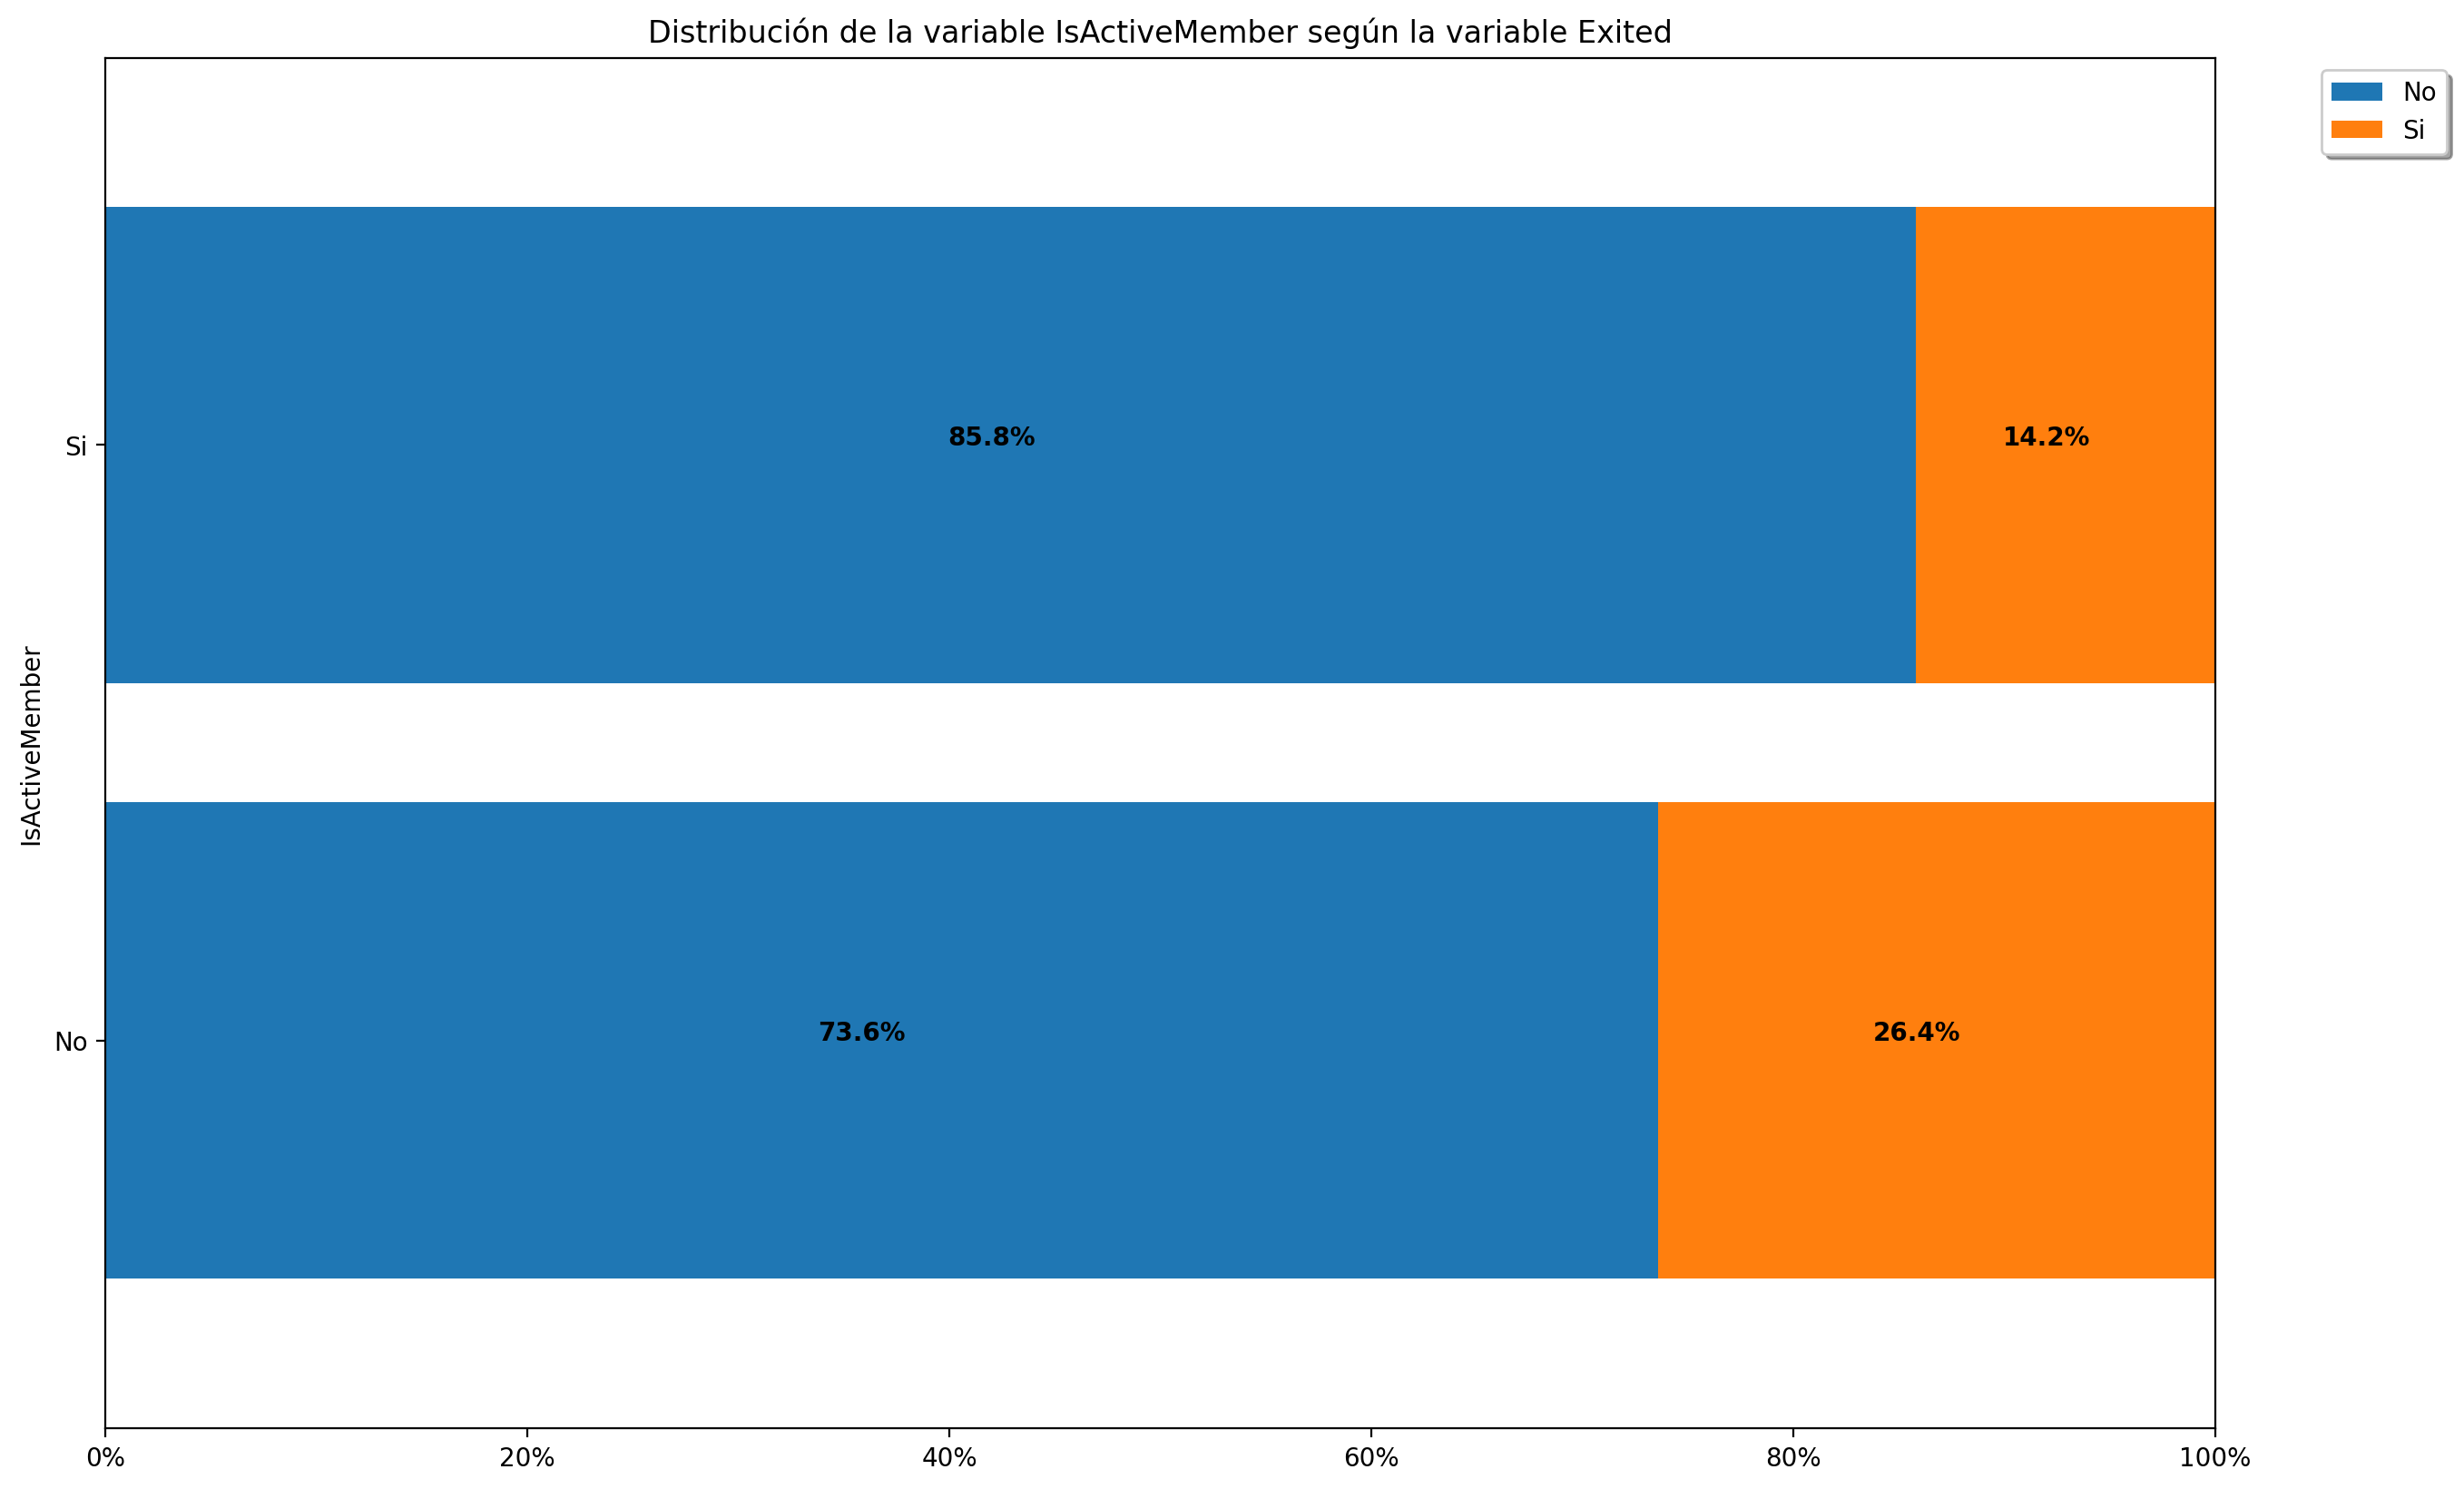

In [161]:
for col in cols_cat_clientes:
    poder_predictivo_categorica(df_clientes,col,"Exited")
    plt.show()

Seleccionemos las siguientes variables, con base en los gráficos anteriores:
-['Age','Balance','NumOfProducts','Geography','isActiveMember','Gender']

- Reducimos los conjuntos de entrenamiento y prueba anteriores a que utilicen sólo éstas variables. 

In [167]:
X_train2=X_train[['Age','Balance', 'NumOfProducts', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender_Female', 'Gender_Male', 'IsActiveMember_No', 'IsActiveMember_Si']]
X_test2= X_test[['Age','Balance', 'NumOfProducts', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender_Female', 'Gender_Male', 'IsActiveMember_No', 'IsActiveMember_Si']] 

In [169]:
### Vamos a hacer la malla como en la pregunta anterior para encontrar los mejores parámetros posibles.
arboles_decision2=pd.DataFrame({
    'max_depth':[],
    'min_samples_split':[],
    'prec_glob':[],
    'err_glob':[],
    'prec_No':[],
    'prec_Si':[]
})

max_depths=range(5,10) ### max_depths de 2 a 20
min_samples_splits= range(2,31) ### min_samples_split de 2 a 20.

start=time.time()
for md in max_depths:
    for mss in min_samples_splits:
        arbol_clientes_4 = DecisionTreeClassifier(max_depth=md,min_samples_split=mss)
        arbol_clientes_4.fit(X_train2.values,y_train)
        prediccion_clientes_4 = arbol_clientes_4.predict(X_test2.values)
        ### Indices Generales
        MC_clientes_4 = confusion_matrix(y_test, prediccion_clientes_3)
        indices = indices_general(MC_clientes_4,list(np.unique(y)))
        arboles_decision2=arboles_decision2.append(
            pd.DataFrame({
                'max_depth':[md],
                'min_samples_split':[mss],
                'prec_glob':[indices['Precisión Global']],
                'err_glob':[indices['Error Global']],
                'prec_No':[indices['Precisión por categoría']['No'][0]],
                'prec_Si':[indices['Precisión por categoría']['Si'][0]]
            }), ignore_index=True)
end=time.time()
print(f"Calculo de Arboles de Decision con la malla duró {end-start} segundos.")
### Modelos con mejor precisión global al inicio
arboles_decision2=arboles_decision2.sort_values(by=['prec_glob'], ascending=False)
arboles_decision2.head(10)

Calculo de Arboles de Decision con la malla duró 1.7658905982971191 segundos.


,max_depth,min_samples_split,prec_glob,err_glob,prec_No,prec_Si
0,5.0,2.0,0.830888,0.169112,0.918173,0.454918
73,7.0,17.0,0.830888,0.169112,0.918173,0.454918
93,8.0,8.0,0.830888,0.169112,0.918173,0.454918
94,8.0,9.0,0.830888,0.169112,0.918173,0.454918
95,8.0,10.0,0.830888,0.169112,0.918173,0.454918
96,8.0,11.0,0.830888,0.169112,0.918173,0.454918
97,8.0,12.0,0.830888,0.169112,0.918173,0.454918
98,8.0,13.0,0.830888,0.169112,0.918173,0.454918
99,8.0,14.0,0.830888,0.169112,0.918173,0.454918
100,8.0,15.0,0.830888,0.169112,0.918173,0.454918


Vemos que nuestra precisión NO mejoró.

En la tarea pasada, el mejor modelo KNN que obtuvimos para este conjunto de datos fue con $k=6$, en el cual tuvimos los siguientes resultados:

Modelo de k vecinos para k = 6 :

Matriz de Confusión
`[[1014   18]
 [ 202   61]]`

Precisión Global:
0.8301158301158301

Error Global:
0.16988416988416988

Precisión por Categoría:
         No        Si
0  0.982558  0.231939

De donde podemos calcular las métricas de forma más completa:

In [172]:
mat_1=MatConf(np.matrix([[1014,18],[202,61]]))
mat_1.dict_medidas

{'Precisión Global': 0.8301158301158301,
 'Error Global': 0.16988416988416988,
 'Precisión Positiva (PP)': 0.23193916349809887,
 'Precisión Negativa (PN)': 0.9825581395348837,
 'Proporción de Falsos Positivos (PFP)': 0.01744186046511628,
 'Proporción de Falsos Negativos (PFN)': 0.7680608365019012,
 'Asertividad Positiva (AP)': 0.7721518987341772,
 'Asertividad Negativa (AN)': 0.8338815789473685}

Creamos entonces un dataframe que compare este modelo de KNN con el mejor modelo de Árboles de Decisión (AD) que obtuvimos en este inciso.

In [174]:
metricas_mejor_KNN=pd.DataFrame({
    'Modelo':['Mejor KNN'],
    'Precisión Global':[0.8301158],
    'Error Global':[0.16988416],
    'Precisión Positiva (PP)':[0.2319391],
    'Precisión Negativa (PN)':[0.98255813],
    'Proporción de Falsos Positivos (PFP)':[0.01744186],
    'Proporción de Falsos Negativos (PFN)':[0.76806083],
    'Asertividad Positiva (AP)':[0.772151],
    'Asertividad Negativa (AN)':[0.8338815]
})

### El arbol que teniamos guardado se llamaba arbol_clientes_5:

prediccion_clientes_5 = arbol_clientes_5.predict(X_test.values)
### Indices Generales
MC_clientes_5 = confusion_matrix(y_test, prediccion_clientes_5)
indices = indices_general(MC_clientes_5,list(np.unique(y)))
medidas2= MatConf(indices['Matriz de Confusión']).dict_medidas
df2=pd.DataFrame({'Modelo':['Mejor AD']})
for key in list(medidas2.keys()):
    df2[key]=medidas2[key]
metricas_mejor_KNN= metricas_mejor_KNN.append(df2)
metricas_mejor_KNN

,Modelo,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
0,Mejor KNN,0.830116,0.169884,0.231939,0.982558,0.017442,0.768061,0.772151,0.833882
0,Mejor AD,0.861004,0.138996,0.323770,0.985728,0.014272,0.676230,0.840426,0.862614


En este caso el modelo de AD se comportó mejor en general.

<div class='question_container'>
    <h2> Pregunta 6 </h2>
    <p>En este ejercicio vamos a predecir números escritos a mano (Hand Written Digit Recognition), la tabla de aprendizaje está en el archivo <span class='code_span'>ZipDataTrainCod.csv</span> y la tabla de testing está en el archivo <span class='code_span'>ZipDataTestCod.csv</span>. En la figura siguiente se ilustran los datos: </p>
    <p> Los datos de este ejemplo vienen de los códigos postales escritos a mano en sobres del correo postal de EE.UU. Las imágenes son de 16 $\times$ 16 en escala de grises, cada pixel va de intensidad de -1 a 1 (de blanco a negro). Las imágenes se han normalizado para tener aproximadamente el mismo tamaño y orientación. La tarea consiste en predecir, a partir de la matriz de 16 $\times$ 16 de intensidades de cada pixel, la identidad de cada imagen (0, 1, ...,  9) de forma rápida y precisa. Si es lo suficientemente precisa, el algoritmo resultante se utiliza como parte de un procedimiento de selección automática para sobres. Este es un problema de clasificación para el cual la tasa de error debe mantenerse muy baja para evitar la mala dirección de correo. La columna 1 tiene la variable a predecir Número codificada como sigue: 0='cero', 1='uno', 2='dos', 3='tres', 4='cuatro', 5='cinco', 6='seis', 7='siete', 8='ocho' y 9='nueve', las demás columnas son las variables predictivas, además cada fila de la tabla representa un bloque 16 $\times$ 16 por lo que la matriz tiene 256 variables predictoras. </p>
    <ol>
        <li>Usando el método de Árboles de Decisión genere un modelo predictivo para la tabla de aprendizaje.</li>
        <li>Con la tabla de testing calcule la matriz de confusión, la precisión global, el error global y la precisión en cada unos de los dígitos. ¿on buenos los resultados?</li>
        <li>Construya un <span class='code_span'>DataFrame</span> que compare el mejor modelo de árboles construido arriba con el mejor modelo construido en la tarea anterior para estos datos. Para esto en cada una de las filas debe aparecer un modelo predictivo y en las columnas aparezcan los índices Precisión Global, Error Global, Precisión Positiva (PP) y Precisión Negativa (PN). ¿Cuál de los modelos es mejor para estos datos? Guarde los datos de este DataFrame, ya que se irá modificando en próximas tareas. </li>
    </ol>
</div>

In [177]:
### Leemos los datos

zipdata_train = pd.read_csv("ZipDataTrainCod.csv",sep=';')
zipdata_test = pd.read_csv("ZipDataTestCod.csv",sep=';')

X_train = zipdata_train.drop(['Numero'],axis=1)
y_train = zipdata_train['Numero']
X_test = zipdata_test.drop(['Numero'],axis=1)
y_test = zipdata_test['Numero']

In [178]:
def get_prec_multi(mat_cfn, labels):
    """
    Regresa la Precisión Global, el Error Global, y la precisión sobre cada dígito.
    """
    suma_total = sum(sum(mat_cfn))
    suma_diag = sum([mat_cfn[i,i] for i in range(mat_cfn.shape[0])])
    prec_global = suma_diag/suma_total
    err_global = 1- prec_global
    prec_digitos={} ### Creamos un diccionario con la precisión de cada dígito.
    prec_digitos['Precisión Global']=prec_global
    prec_digitos['Error Global']=err_global
    for i in range(mat_cfn.shape[0]):
        prec_este_digito = mat_cfn[i,i]/sum([mat_cfn[i,j] for j in range(mat_cfn.shape[0])])
        prec_digitos[f'Precisión "{labels[i]}"']= prec_este_digito
    return prec_digitos

In [180]:
arbol_digitos_1 = DecisionTreeClassifier()
arbol_digitos_1.fit(X_train.values,y_train)
prediccion_digitos_1 = arbol_digitos_1.predict(X_test.values)
### Indices Generales
MC_digitos_1 = confusion_matrix(y_test, prediccion_digitos_1)

C:\Users\jimmy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\jimmy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


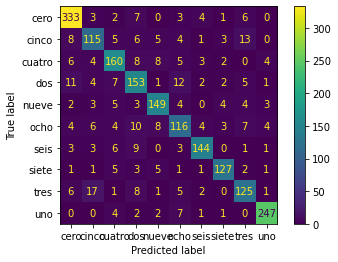

In [182]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(arbol_digitos_1, X_test, y_test)

In [183]:
labels_dig=['cero','cinco','cuatro','dos','nueve','ocho','seis','siete','tres','uno']
get_prec_multi(MC_digitos_1, labels_dig)

{'Precisión Global': 0.8315894369706028,
 'Error Global': 0.16841056302939716,
 'Precisión "cero"': 0.9275766016713092,
 'Precisión "cinco"': 0.71875,
 'Precisión "cuatro"': 0.8,
 'Precisión "dos"': 0.7727272727272727,
 'Precisión "nueve"': 0.8418079096045198,
 'Precisión "ocho"': 0.6987951807228916,
 'Precisión "seis"': 0.8470588235294118,
 'Precisión "siete"': 0.8639455782312925,
 'Precisión "tres"': 0.7530120481927711,
 'Precisión "uno"': 0.9356060606060606}

En la tarea anterior obtuvimos los siguientes resultados utilizando un KNN con `k=5`: (Lo he copiado de lo que obtuve en la tarea).

In [189]:
tarea_pasada= {'Precisión Global': [0.9451918285999004], 
 'Error Global': [0.05480817140009964],
 'Precisión "cero"': [0.9860724233983287], 
 'Precisión "cinco"': [0.9125], 
 'Precisión "cuatro"': [0.92], 
 'Precisión "dos"': [0.9191919191919192], 
 'Precisión "nueve"': [0.9548022598870056], 
 'Precisión "ocho"': [0.9216867469879518], 
 'Precisión "seis"': [0.9529411764705882], 
 'Precisión "siete"': [0.9319727891156463], 
 'Precisión "tres"': [0.9156626506024096], 
 'Precisión "uno"': [0.9772727272727273]}
tarea_pasada

{'Precisión Global': [0.9451918285999004],
 'Error Global': [0.05480817140009964],
 'Precisión "cero"': [0.9860724233983287],
 'Precisión "cinco"': [0.9125],
 'Precisión "cuatro"': [0.92],
 'Precisión "dos"': [0.9191919191919192],
 'Precisión "nueve"': [0.9548022598870056],
 'Precisión "ocho"': [0.9216867469879518],
 'Precisión "seis"': [0.9529411764705882],
 'Precisión "siete"': [0.9319727891156463],
 'Precisión "tres"': [0.9156626506024096],
 'Precisión "uno"': [0.9772727272727273]}

Comparamos ambos modelos en un `DataFrame`:

In [193]:
metricas_tarea_pasada=pd.DataFrame(tarea_pasada)
metricas_esta_tarea=get_prec_multi(MC_digitos_1, labels_dig)
for key in list(metricas_esta_tarea.keys()):
    metricas_esta_tarea[key]=[metricas_esta_tarea[key]] ### Convertir cada valor del diccionario a una lista, para hacerlo como DataFrame
    
metricas_esta_tarea=pd.DataFrame(metricas_esta_tarea)
metricas_esta_tarea=metricas_esta_tarea.append(metricas_tarea_pasada)
metricas_esta_tarea.index = ['Esta Tarea (AD)','Tarea Pasada (KNN)']
metricas_esta_tarea

,Precisión Global,Error Global,"Precisión ""cero""","Precisión ""cinco""","Precisión ""cuatro""","Precisión ""dos""","Precisión ""nueve""","Precisión ""ocho""","Precisión ""seis""","Precisión ""siete""","Precisión ""tres""","Precisión ""uno"""
Esta Tarea (AD),0.831589,0.168411,0.927577,0.71875,0.80,0.772727,0.841808,0.698795,0.847059,0.863946,0.753012,0.935606
Tarea Pasada (KNN),0.945192,0.054808,0.986072,0.91250,0.92,0.919192,0.954802,0.921687,0.952941,0.931973,0.915663,0.977273


En este caso vemos que el modelo con Árboles de Decisión que hemos ajustado en este inciso se comporta peor que el modelo con KNN que ajustamos en la tarea pasada.